# Principal Component Analysis (PCA)

Examples adapted from https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [63]:
import numpy as np
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['figure.figsize'] = (5, 5)

---
## Generate some random correlated two dimensional data.

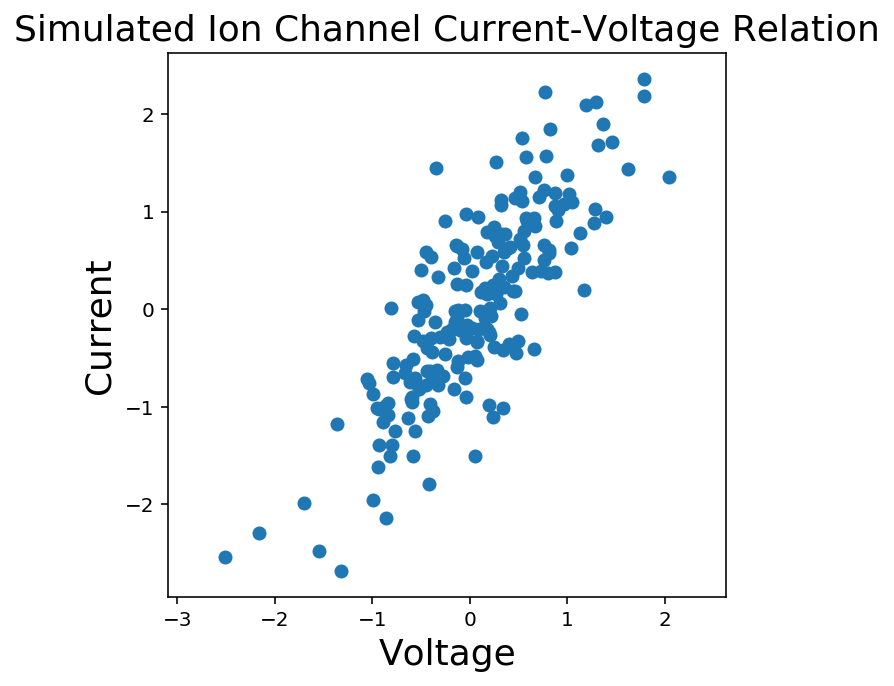

In [64]:
# Generate a random cloud of (x, y) points.
np.random.seed(1)
xy = np.random.randn(200, 2)  # 200 (x, y) points# Apply a random transformation (rotation, scaling) to the points.
transformation = np.random.rand(2, 2)  # 2x2 random transformation matrix
xy = xy @ transformation  # apply the transformation to the points

plt.scatter(xy[:,0], xy[:,1])
plt.xlabel('Voltage')
plt.ylabel('Current')
plt.title('Simulated Ion Channel Current-Voltage Relation')
plt.axis('equal');

---
## PCA analysis of the two dimensional data above.

## <font color=blue>Learning Objectives</font>

1. You will visualize the process of changing our perspective to align with the variance in the data.
2. You will visualize the effects of projecting the data onto a smaller number of principal components.
3. You will be able to interpret the principal components as axes in the original data space.

In [65]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(xy)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [66]:
# the orthogonal vectors that best explain the variance in the data
print(pca.components_)

[[-0.56295862 -0.82648508]
 [-0.82648508  0.56295862]]


In [67]:
# how much variance each of the above vectors accounts for
print(pca.explained_variance_)

[1.32170439 0.11909325]


In [68]:
# this function will draw an arrow from point v0 to point v1
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->', linewidth=2, color='black', shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

1.3217043946525873 [-0.56295862 -0.82648508]
0.11909325141258627 [-0.82648508  0.56295862]


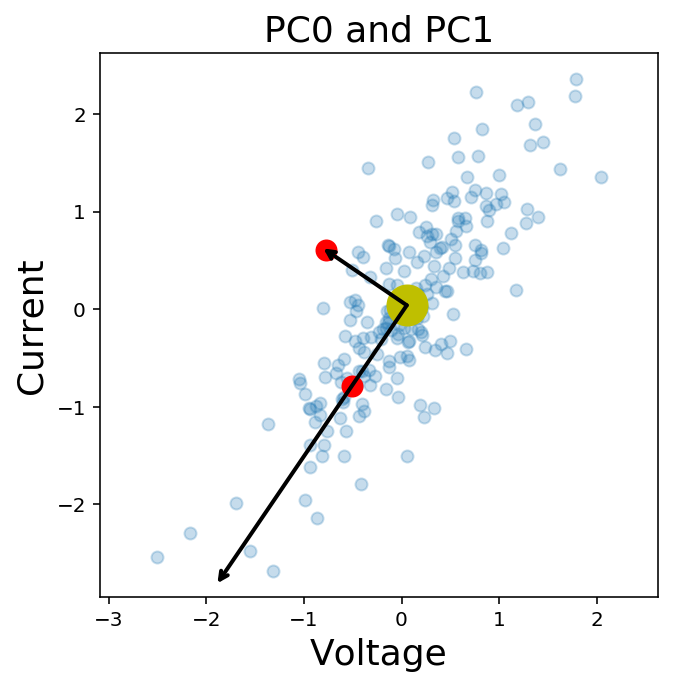

In [69]:
# replot the data points overlaid with arrows showing the principal components
plt.scatter(xy[:,0], xy[:,1], alpha=0.25)
plt.plot(pca.mean_[0], pca.mean_[1], 'yo', ms=20)

for length, pcaxis in zip(pca.explained_variance_, pca.components_):
    print(length, pcaxis)
    v = pcaxis * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
    pt = pca.mean_ + pcaxis
    plt.plot(pt[0], pt[1], 'ro', ms=10)

plt.xlabel('Voltage')
plt.ylabel('Current')
plt.title('PC0 and PC1')
plt.axis('equal');

---
## Rotate the data so that we look at it from the perspective of the principal component axes PC0 and PC1.

## This does NOT change the data, just the perspective from which we view it!

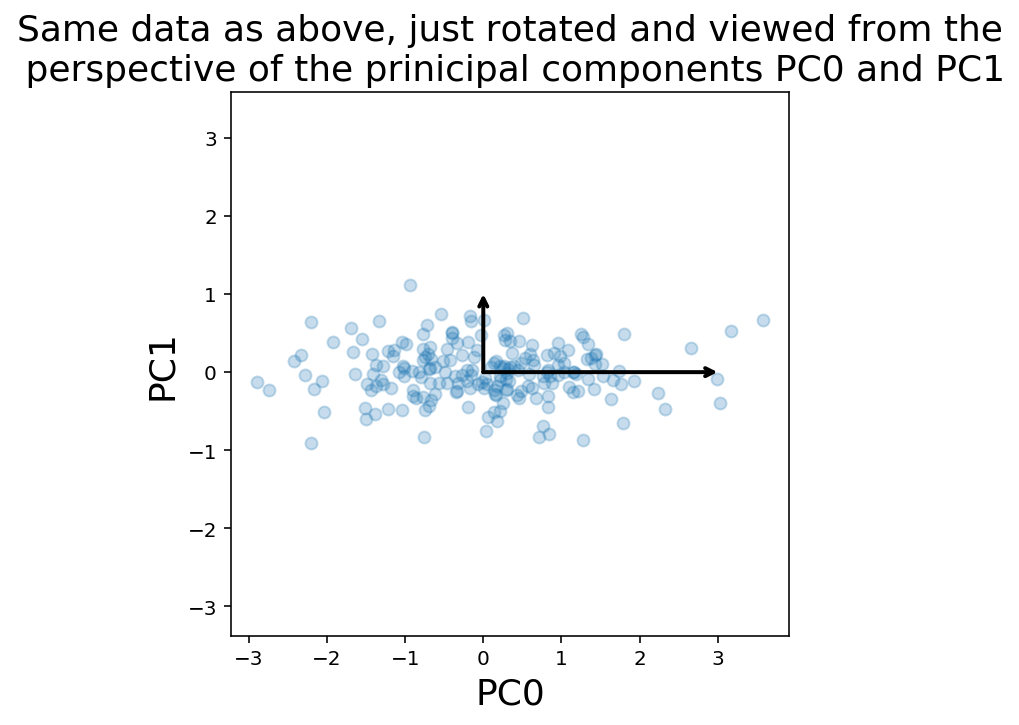

In [70]:
pc = pca.transform(xy)

plt.scatter(pc[:,0], pc[:,1], alpha=0.25)
draw_vector((0, 0), (3, 0))
draw_vector((0, 0), (0, 1))
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('Same data as above, just rotated and viewed from the\n perspective of the prinicipal components PC0 and PC1')
plt.axis('equal');

---
## Dimensionality reduction

* Most of the variance in the data is along PC0.
* We can opt to ignore the variance along PC1.
* This amounts to projecting the data onto PC0.
* We lose some information, but it is the smallest component of variation in the data.
* In return, we have compressed the data from two to one dimensional.

xy: (200, 2)
pc: (200, 1)


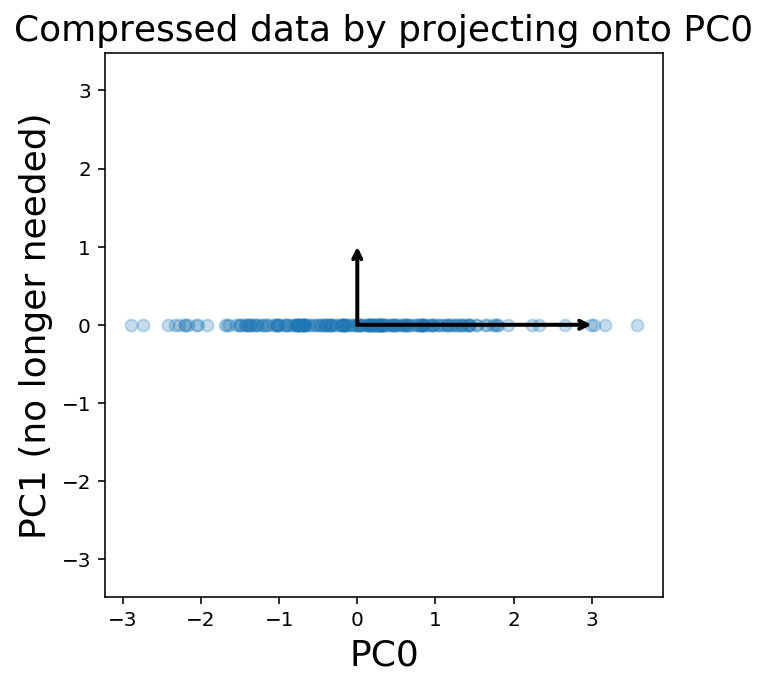

In [71]:
# redo PCA, but specify only a single component
pca = PCA(n_components=1)
pca.fit(xy)

# transform to PCA coordinates
pc = pca.transform(xy)

# see that we have compressed the data from two to one dimensional
print("xy:", xy.shape)
print("pc:", pc.shape)

# plot compressed data in PCA coordinates
plt.scatter(pc[:], np.zeros(pc.shape), alpha=0.25)
draw_vector((0, 0), (3, 0))
draw_vector((0, 0), (0, 1))
plt.xlabel('PC0')
plt.ylabel('PC1 (no longer needed)')
plt.title('Compressed data by projecting onto PC0')
plt.axis('equal');

---
## Rotate back from PC axes perspective to original data perspective.

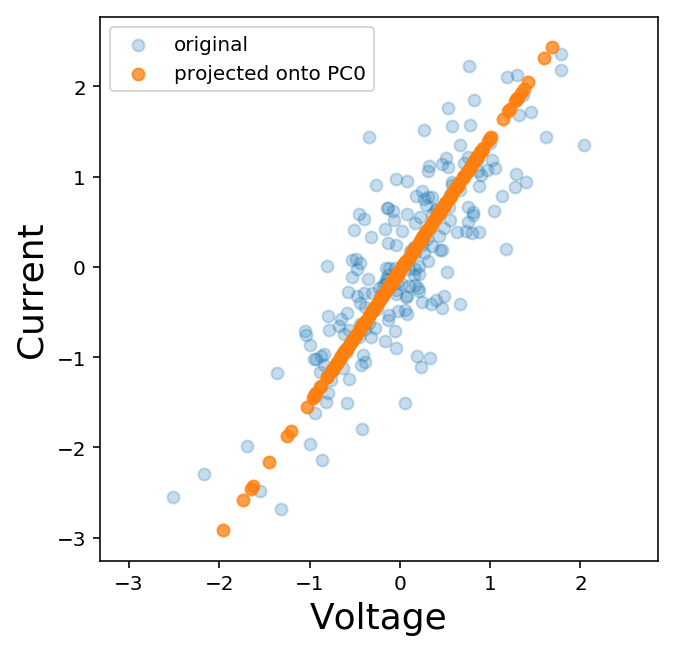

In [72]:
# go back from PCA coordinates to our data's original coordinates
projected = pca.inverse_transform(pc)

# plot original data overlaid with PCA compressed data
plt.scatter(xy[:,0], xy[:,1], alpha=0.25, label='original')
plt.scatter(projected[:,0], projected[:,1], alpha=0.75, label='projected onto PC0')
plt.xlabel('Voltage')
plt.ylabel('Current')
plt.legend(loc='best')
plt.axis('equal');

---
## What are PC0 and PC1?

* ### They're rotated orthogonal axes in the original Current vs. Voltage space.
* ### PC0 and PC1 are each different mixtures of Current and Voltage.

---
## PCA cares about variance in the data.

* ### If the units of the different dimensions are different and their scales are widely different, then PCA will tend to maximize the contribution of the dimension with the largest units.
* ### To keep this from happening, you should in such cases first standardize the data in each dimension, then perform PCA on the standardized data. This way, the variance in each dimension will be treated equally.

---
## How many PCs should you choose?

* Often 2 or 3 are chosen simply to make it easier to visualize the data.
* Otherwise, you can look to see at what point adding more PCs does not do much better at explaining the variation in the data.

## <font color=blue>Learning Objectives</font>

1. You will be able to quantify the amount of variance explained by any given number of principal components.

[1.32170439 0.11909325]
[0.91734214 0.08265786]


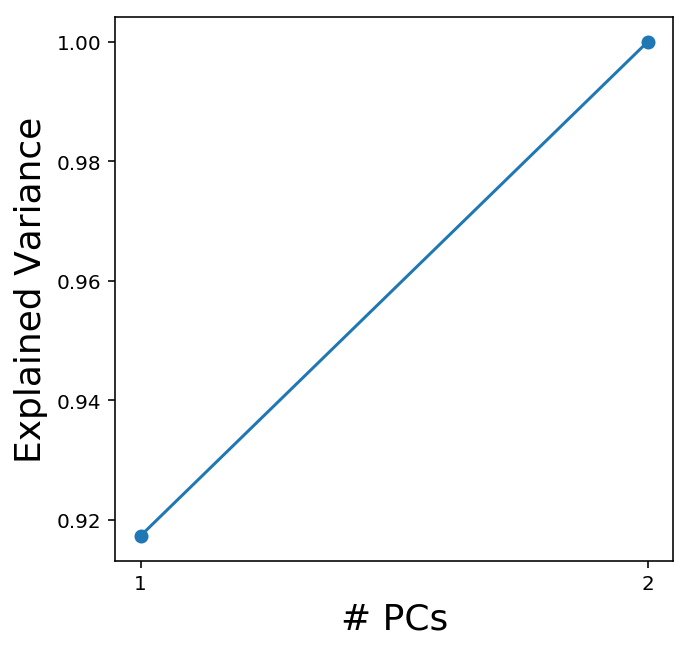

In [73]:
pca = PCA(n_components=2)
pca.fit(xy)

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

plt.plot(np.arange(1, 3), np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xticks([1, 2])
plt.xlabel('# PCs')
plt.ylabel('Explained Variance');

---
# A slightly more complicated example.

## <font color=blue>Learning Objectives</font>

1. You will see how the concepts above relate to a higher dimensional data set.

In [74]:
from sklearn import datasets
import pandas as pd

diabetes = datasets.load_diabetes()
X = diabetes.data
features = "age sex bmi map tc ldl hdl tch ltg glu".split()
df = pd.DataFrame(X, columns=features)
df

age       sex       bmi       map        tc       ldl       hdl  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017282 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081414  0.083740  0.027809  0.173816   

          tch       ltg       glu  
0   -0.002592  0.019908 -0.017646  
1   -0.039493 -0.068330 -0.092204  
2   -0.002592  0.002864 -0.025930  
3    0.034309  0.022692 -0.009362  
4   -0.002592 -0.031991 -0.046641  
..        ...       ...       ...  
437 -0.002592  0.031193  0.007207  
438  0.034309 -0.018118  0.044485  
439 -0.011080 -0.046879  0.015491  
440  0.026560  0.044528 -0.025930  
441 -0.039493 -0.004220  0.003064  

[442 rows x 10 columns]

## Each of 442 patients is a data point.

* ### Each patient data point is 10 dimensional (one dimension for each feature).
* ### If it were possible to visualize 10 dimensions, we could plot each patient as a point on a graph with 10 axes (one for each feature).

In [75]:
X.shape

(442, 10)

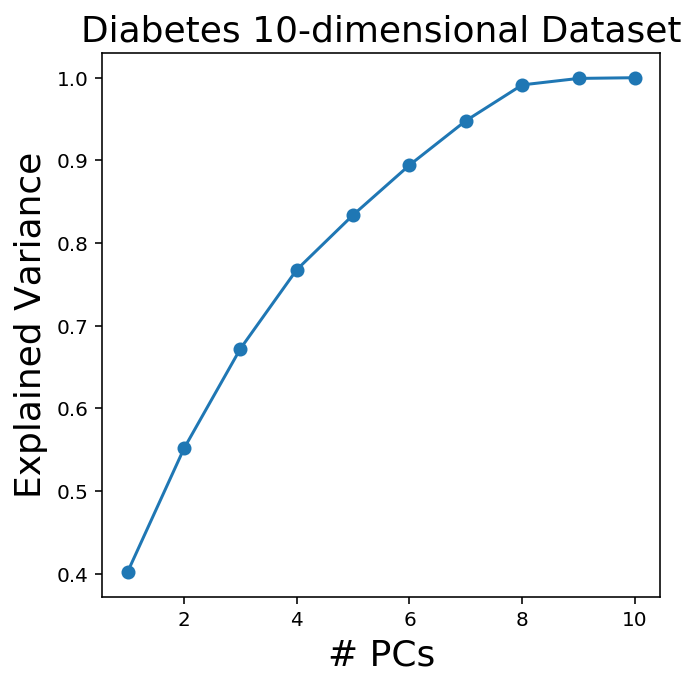

In [76]:
pca = PCA(n_components=10)
pca.fit(X)

plt.plot(np.arange(1, 11), np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xlabel('# PCs')
plt.ylabel('Explained Variance');
plt.title('Diabetes 10-dimensional Dataset');

## Let's use PCA to compress the data by using only 6 values (6 dimensions) to explain each patient. This will explain ~90% of the variance in the data.

In [77]:
pca = PCA(n_components=6)
pca.fit(X)

pc = pca.transform(X)

print('X  ', X.shape)
print('pc ', pc.shape)

X   (442, 10)
pc  (442, 6)


## We did NOT throw away 4 of the original features!!!

* ### We rotated our perspective and then compressed the data along 4 of the axes from our rotated point of view.
* ### From the rotated perspective, we ONLY NEED 6 values to describe each patient because the values along 4 of the axes were all compressed to zero.
* ### After compressing if we rotate back to our original feature space (point of view), then each patient will be a point in our original 10-dimensional space.
* ### However, the data points will NOT be exactly what they were before compression. Some of the variance in the data will have been lost by projecting the data onto only 6 PCs.

In [78]:
projected = pca.inverse_transform(pc)

print('X         ', X.shape)
print('pc        ', pc.shape)
print('projected ', projected.shape)

X          (442, 10)
pc         (442, 6)
projected  (442, 10)


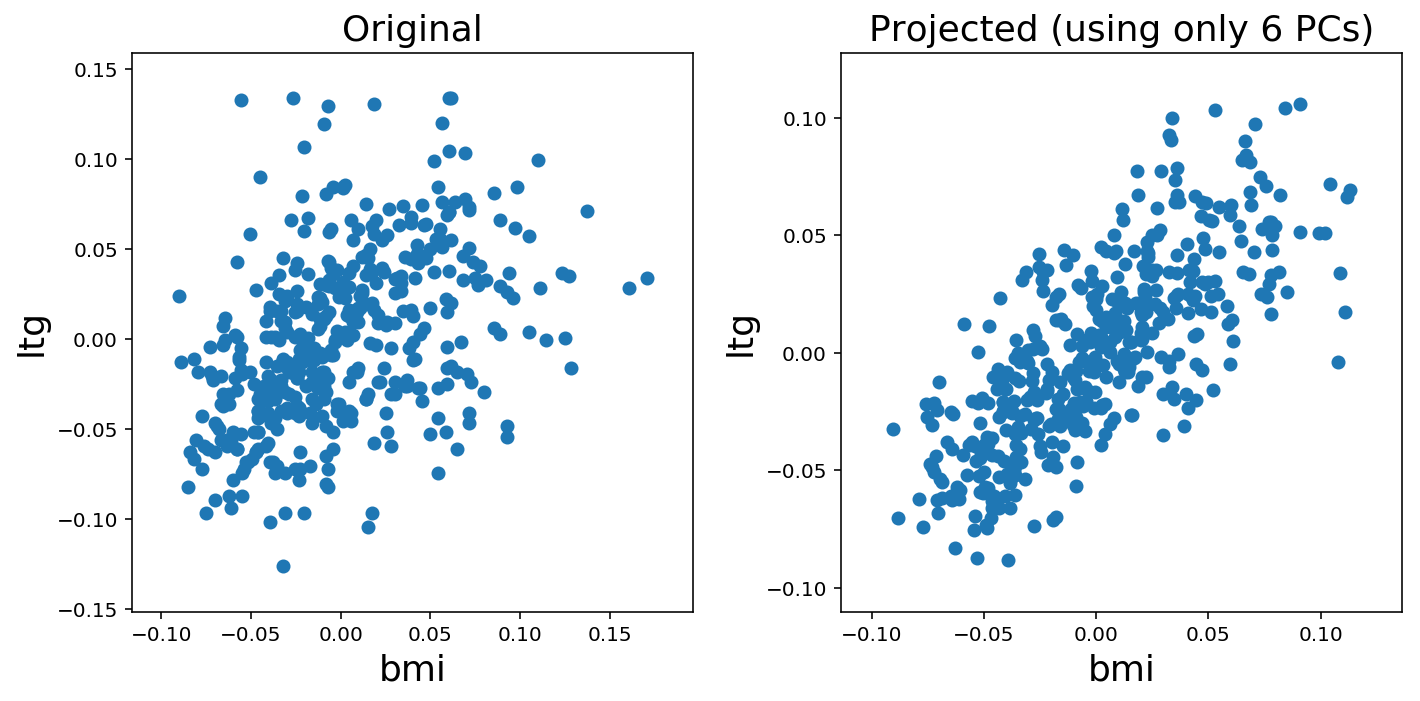

In [79]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.scatter(X[:,2], X[:,8])
plt.xlabel('bmi')
plt.ylabel('ltg')
plt.title('Original');

plt.subplot(122)
plt.scatter(projected[:,2], projected[:,8])
plt.xlabel('bmi')
plt.ylabel('ltg')
plt.title('Projected (using only 6 PCs)');

plt.tight_layout();

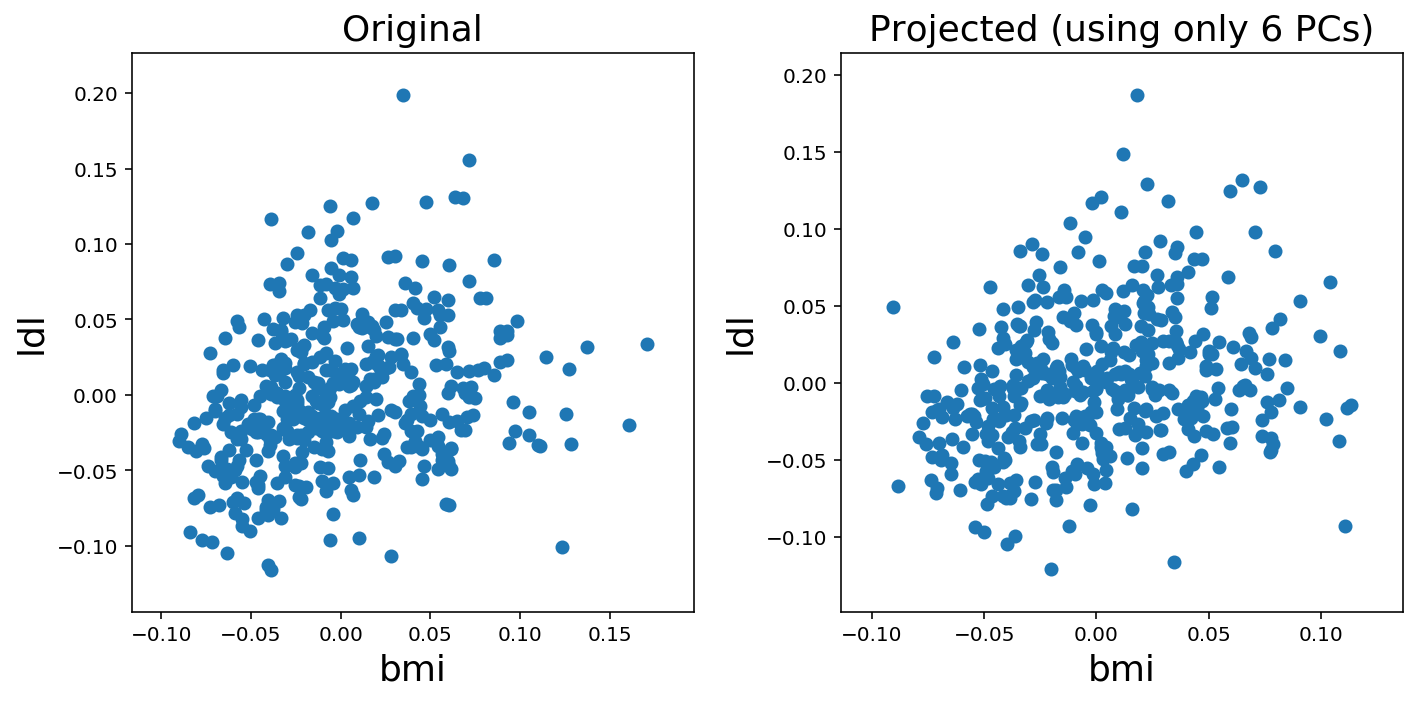

In [80]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.scatter(X[:,2], X[:,5])
plt.xlabel('bmi')
plt.ylabel('ldl')
plt.title('Original');

plt.subplot(122)
plt.scatter(projected[:,2], projected[:,5])
plt.xlabel('bmi')
plt.ylabel('ldl')
plt.title('Projected (using only 6 PCs)');

plt.tight_layout();

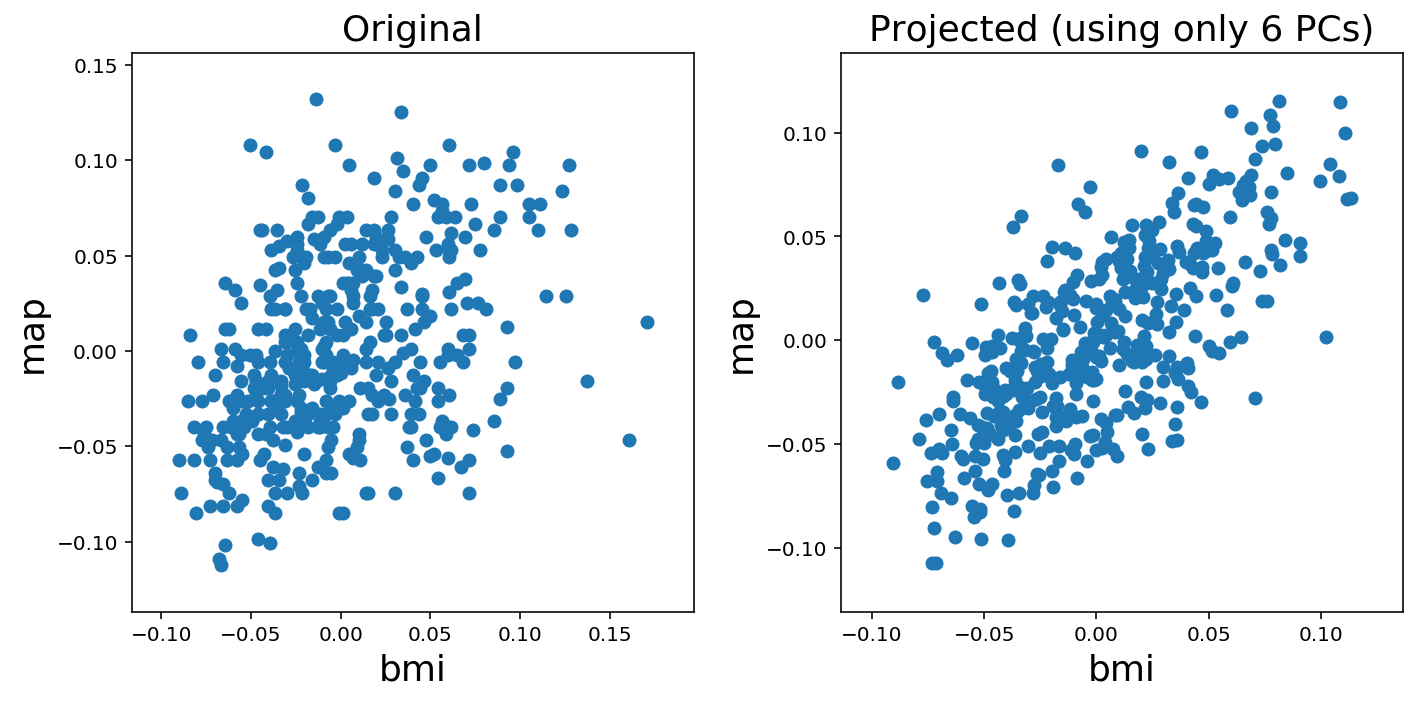

In [81]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.scatter(X[:,2], X[:,3])
plt.xlabel('bmi')
plt.ylabel('map')
plt.title('Original');

plt.subplot(122)
plt.scatter(projected[:,2], projected[:,3])
plt.xlabel('bmi')
plt.ylabel('map')
plt.title('Projected (using only 6 PCs)');

plt.tight_layout();

## So what are the PCs?

* ### They are the rotated coordinate axes (well, 6 of the 10 as we ignored 4 of them).
* ### The rotates axes are mixtures of the original 10 features axes.
* ### So each PC is a mixture of the original 10 features.

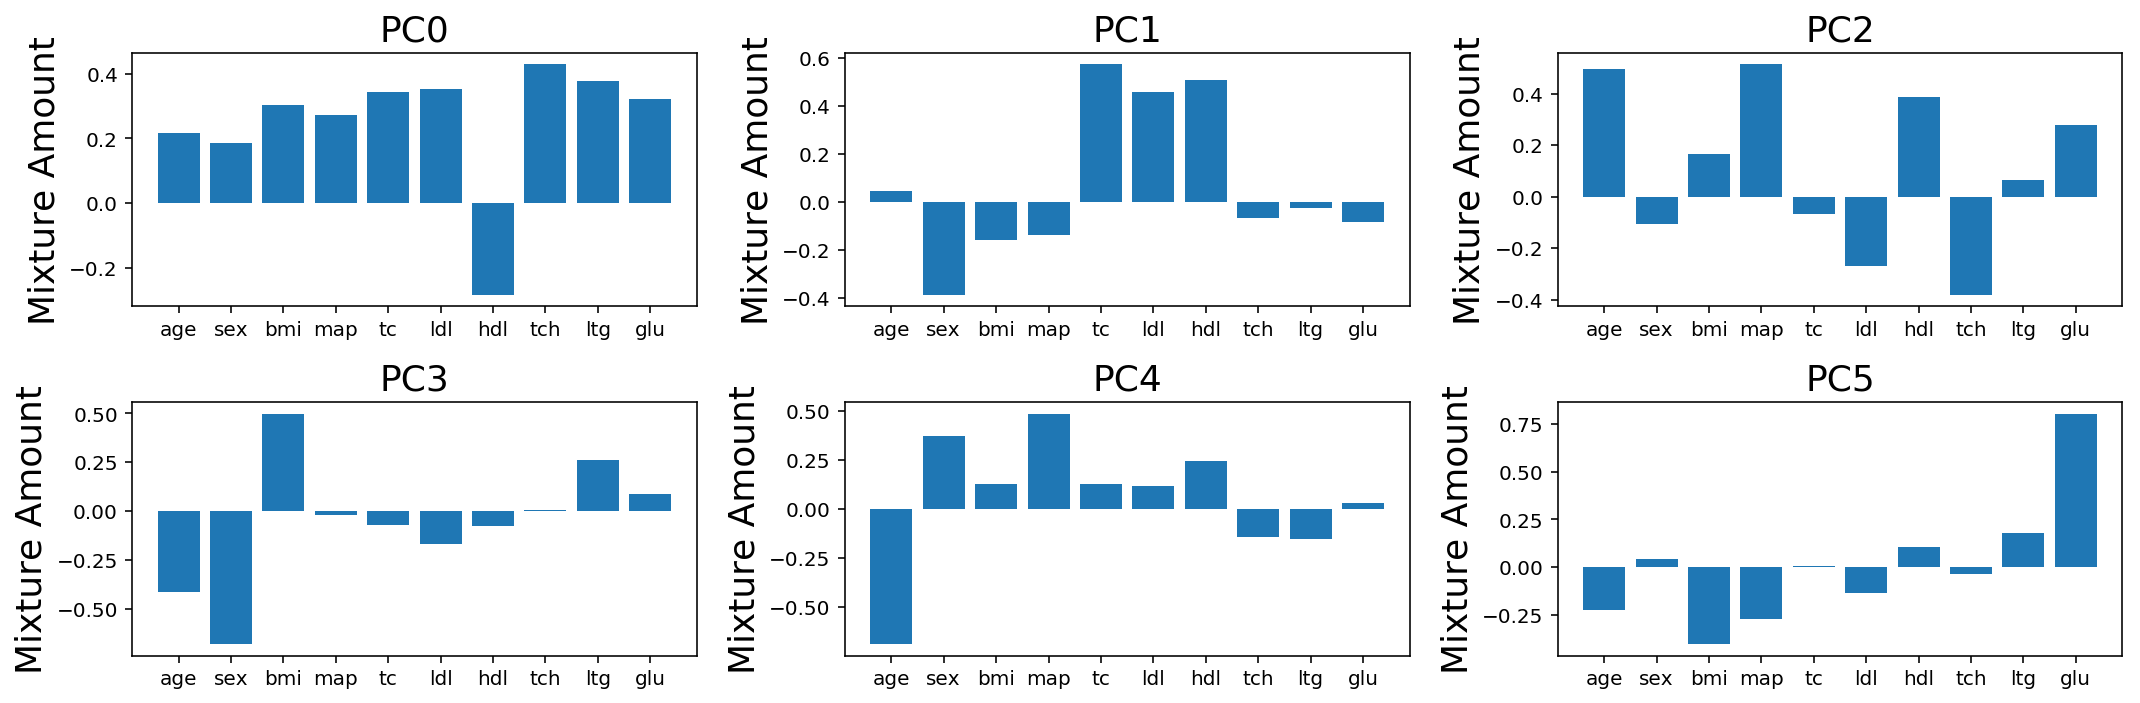

In [82]:
plt.figure(figsize=(15, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.bar(range(10), pca.components_[i,:])
    plt.xticks(range(10), features)
    plt.ylabel('Mixture Amount')
    plt.title(f'PC{i}')
plt.tight_layout();

---
# Example with higher dimensional data (e.g. images).

## <font color=blue>Learning Objectives</font>

1. You will be able to apply the concepts above to images.

## Each 8x8 grayscale image is a point in a 64-dimensional space representing the instensity of each of the 64 pixels in the image.

In [83]:
from sklearn.datasets import load_digits
digits = load_digits()

print(digits.data.shape)
print(digits.target.shape)

(1797, 64)
(1797,)


## Each row of `digits.data` is a 64-dimensional data point representing an image of a hand drawn digit.

## `digits.target` are the numerical values 0-9 that each of the 1797 images correspond to.

0

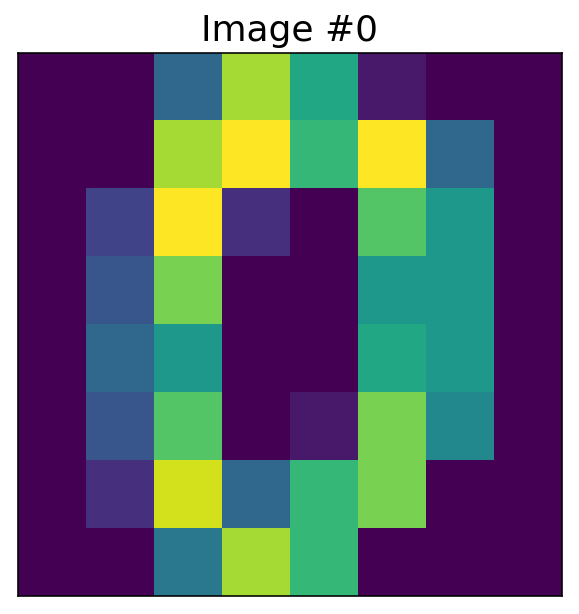

In [84]:
i = 0

plt.imshow(digits.data[i,:].reshape(8, 8))
plt.xticks([])
plt.yticks([]);
plt.title(f'Image #{i}')

digits.target[i]

In [85]:
def plot_digits(images, rows=5, cols=10):
    fig, ax = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
    k = 0
    for i in range(rows):
        for j in range(cols):
            ax[i,j].imshow(images[k,:].reshape(8, 8))
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            k += 1

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 9 5 5 6 5 0 9 8 9]
[8 4 1 7 7 3 5 1 0 0]


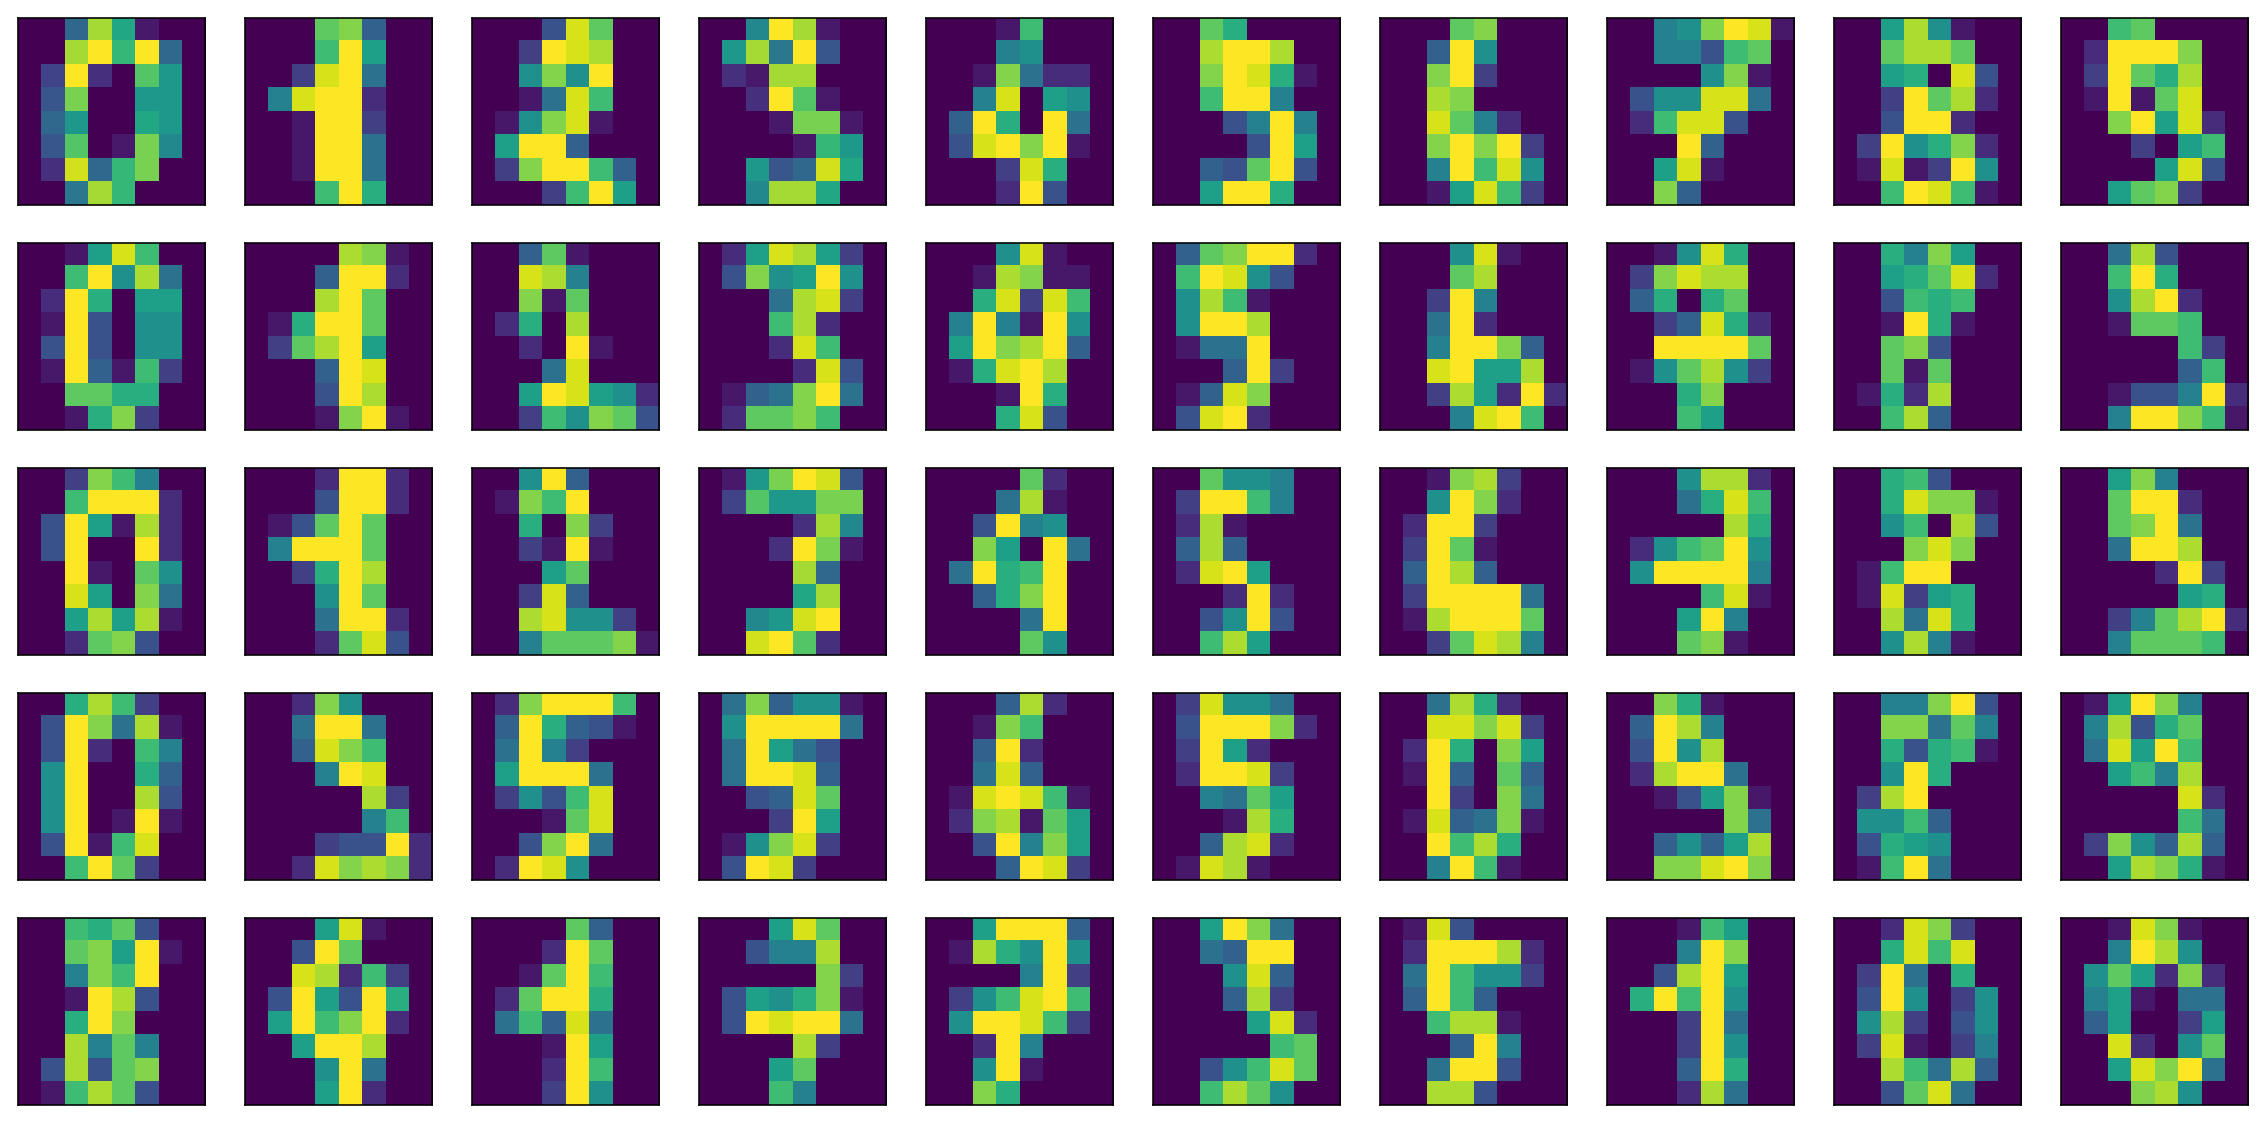

In [86]:
plot_digits(digits.data)

for i in range(5):
    print(digits.target[i * 10:i * 10 + 10])

## Project 64-dimensional images onto a 2-dimensional space for visualization.

In [87]:
pca = PCA(2)  # project from 64 to 2 dimensions
pc = pca.fit_transform(digits.data)

print(digits.data.shape)
print(pc.shape)

(1797, 64)
(1797, 2)


## These two dimensions are mixtures of the original 64 dimensions (i.e. mixtures of the original pixel intensities).

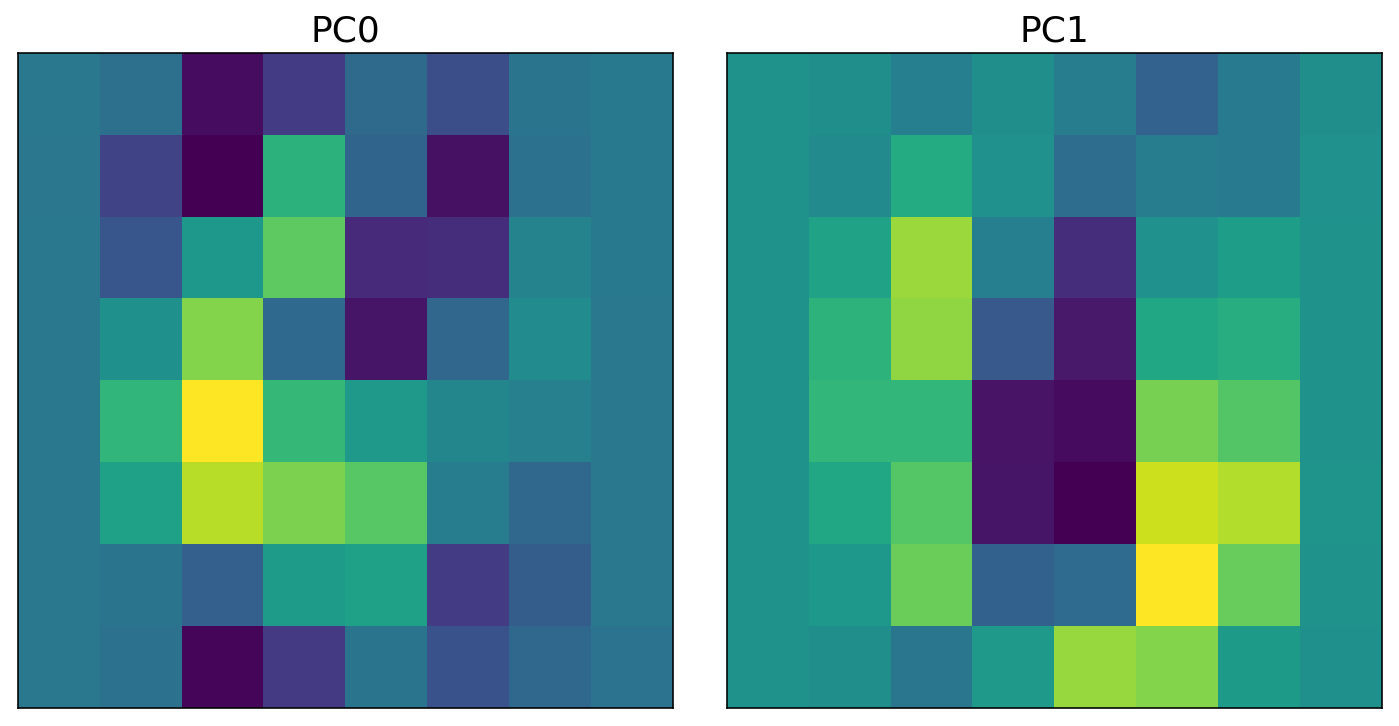

In [88]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(pca.components_[0].reshape(8, 8))
plt.title('PC0');
plt.xticks([])
plt.yticks([]);

plt.subplot(122)
plt.imshow(pca.components_[1].reshape(8, 8))
plt.title('PC1');
plt.xticks([])
plt.yticks([]);

plt.tight_layout();

## How do the images cluster according to their digit value in this vastly reduced 2-dimensional space?

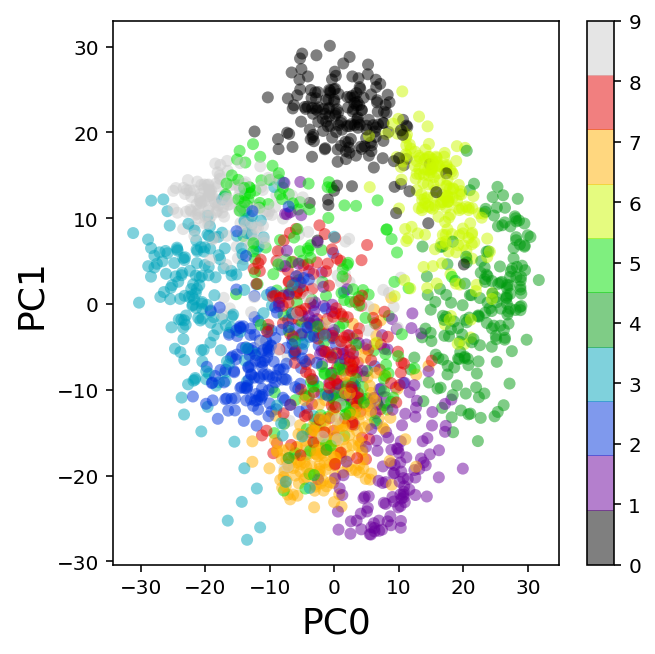

In [89]:
plt.scatter(pc[:,0], pc[:,1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.colorbar();

## What do the images look like after projecting onto only two PCs?

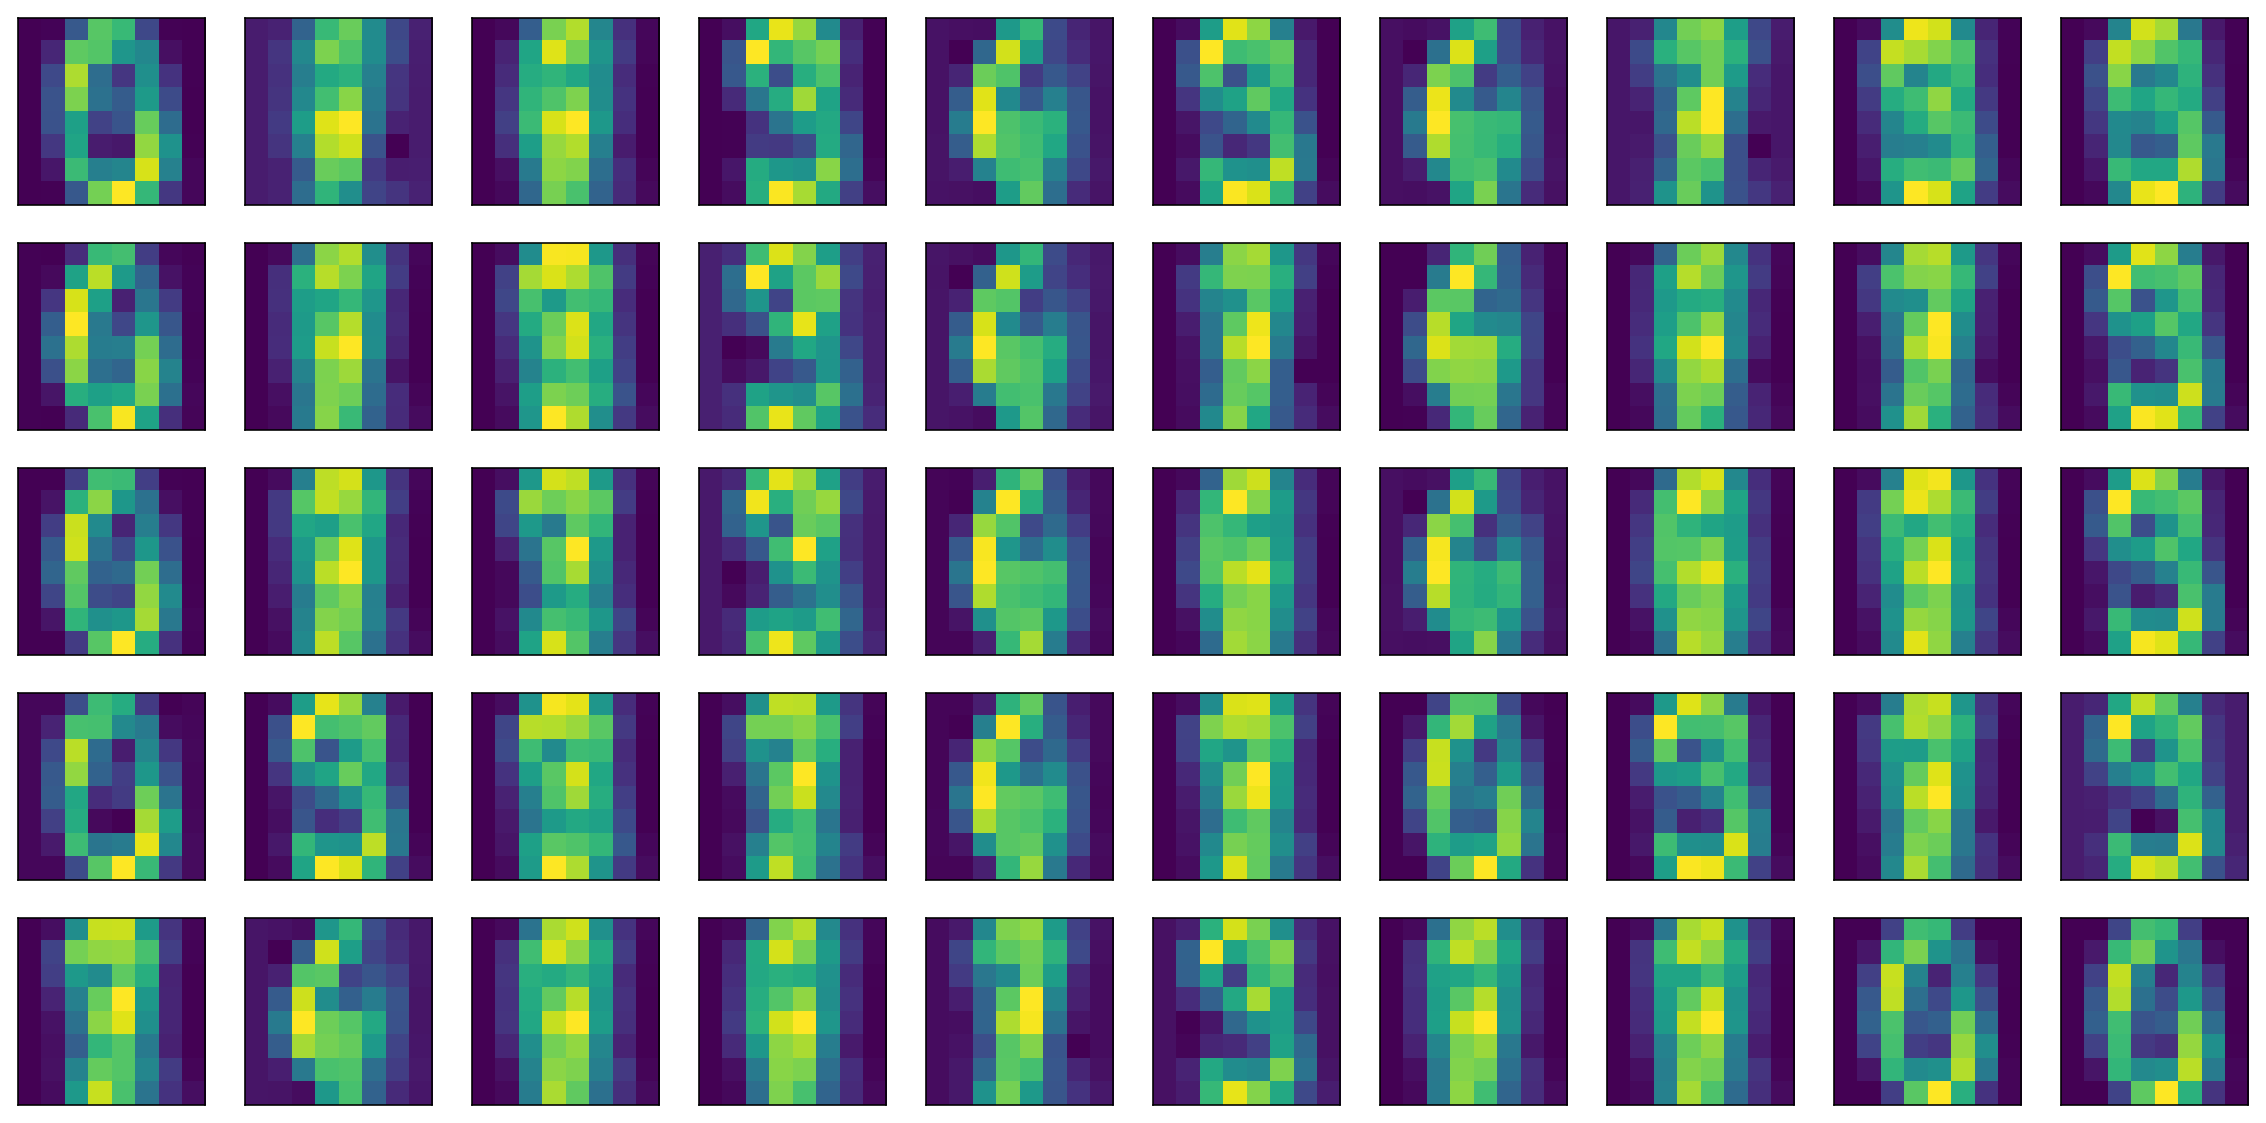

In [90]:
projected = pca.inverse_transform(pc)

plot_digits(projected)

## How well did we do at explaining the variance in the image data with only two PCs?

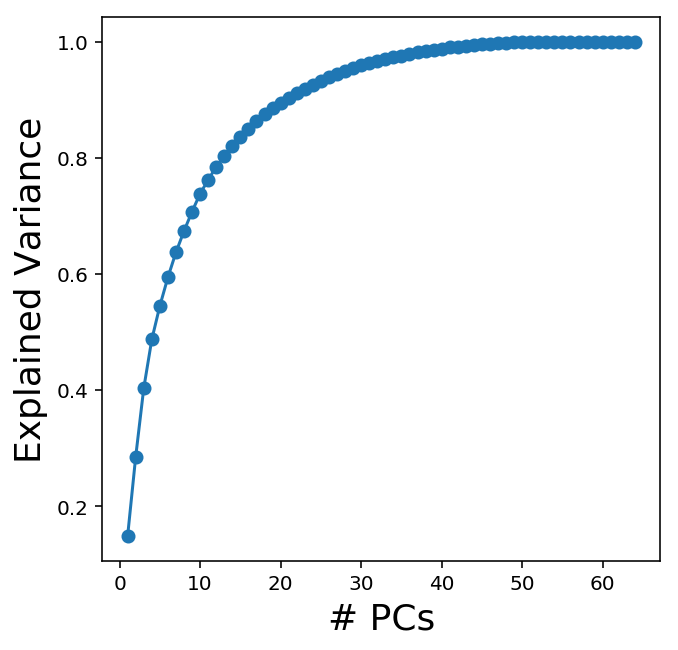

In [91]:
pca = PCA()
pca.fit_transform(digits.data)

plt.plot(np.arange(1, 65), np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xlabel('# PCs')
plt.ylabel('Explained Variance');

---
## PCA as a filter for noisy data

## <font color=blue>Learning Objectives</font>

1. You will see how PCA can be used as a filter to remove noise.

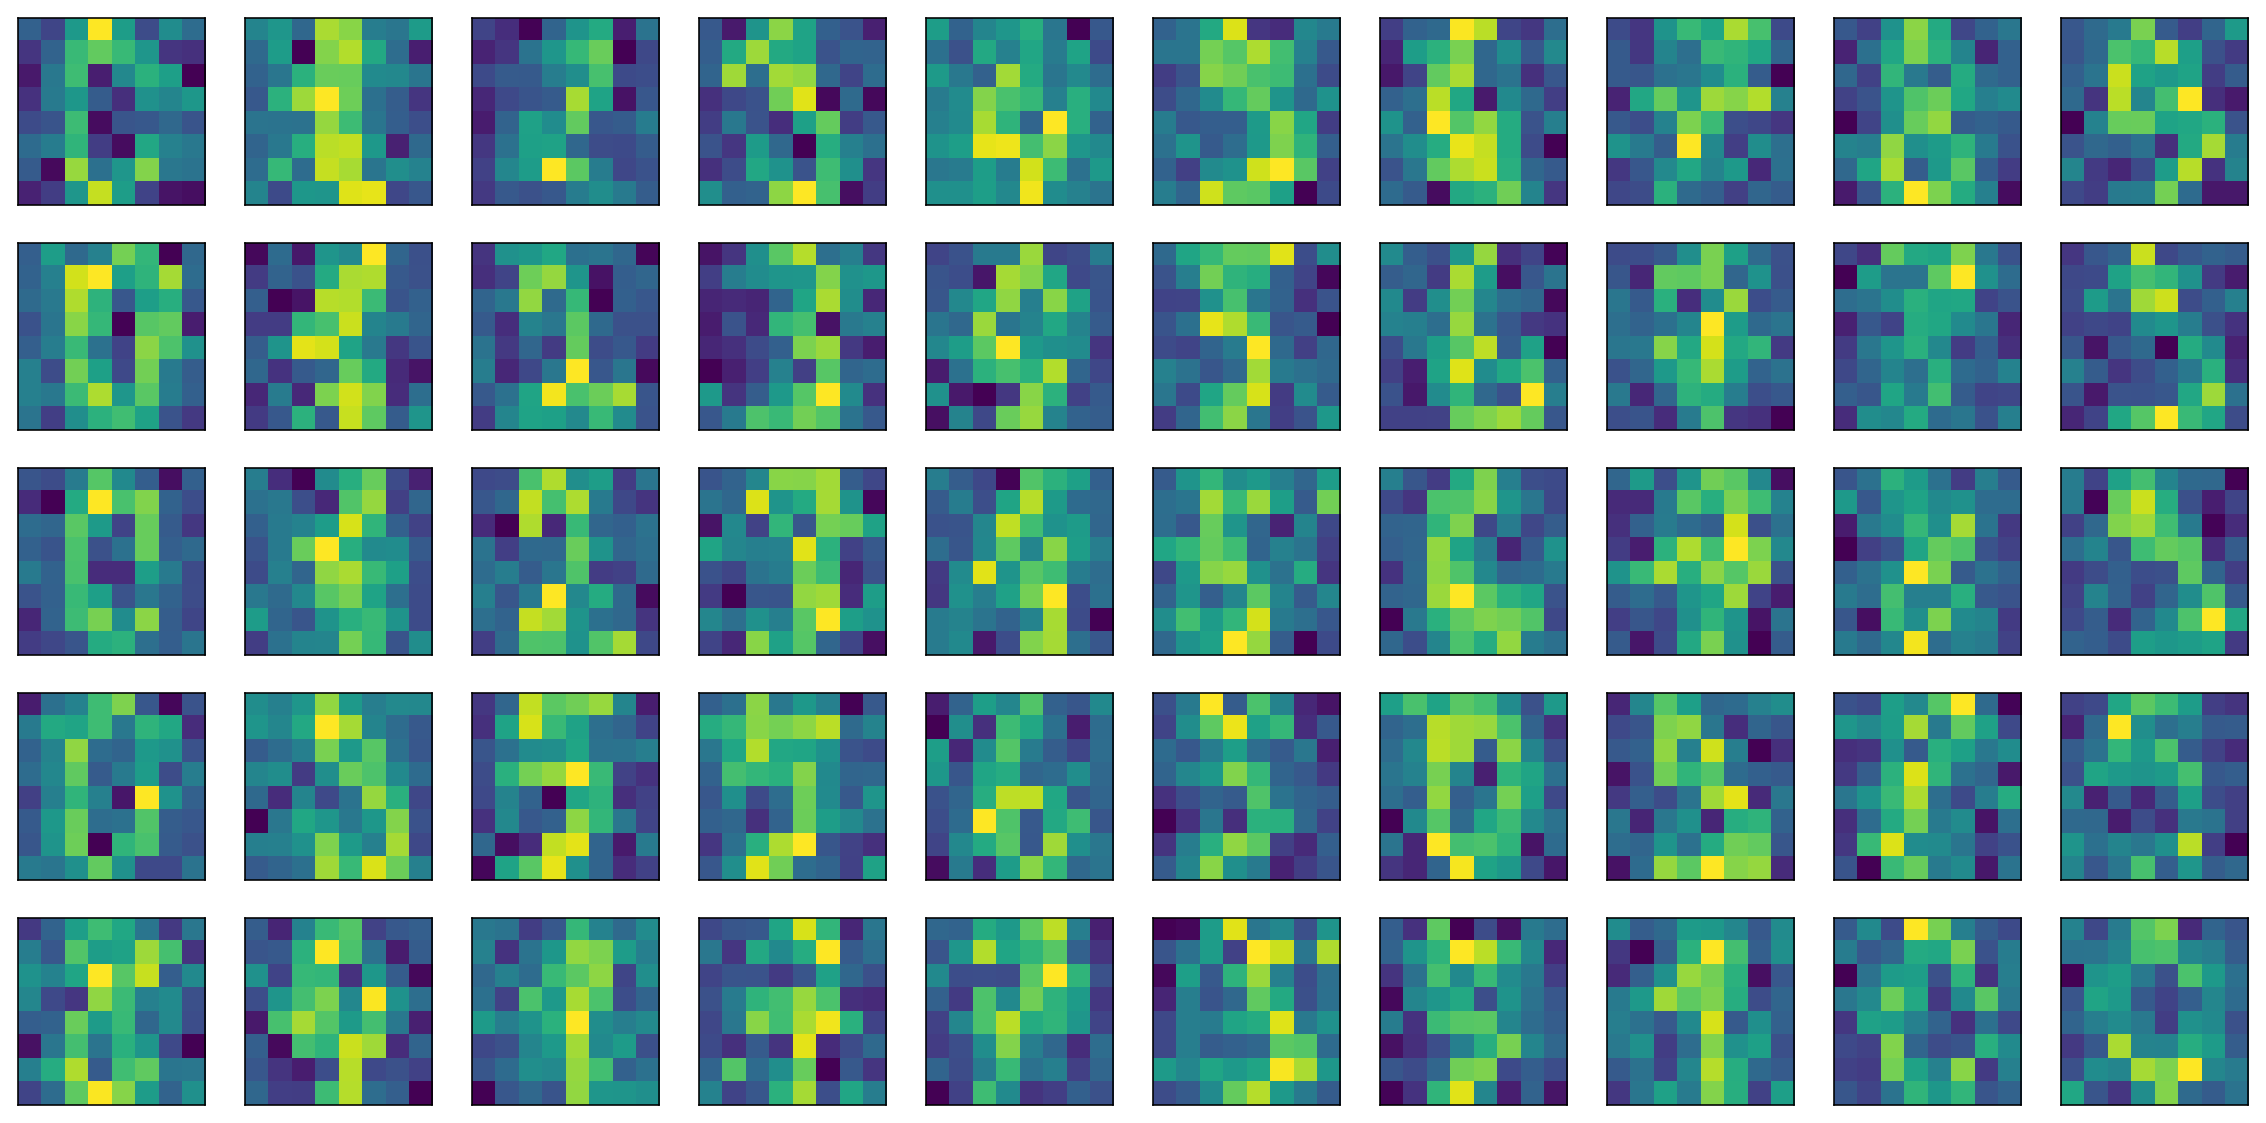

In [92]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)

plot_digits(noisy)

In [93]:
# PCA that preserves 50% of the variance in the data
pca = PCA(0.50)
pca.fit(noisy)

print(pca.n_components_)

12


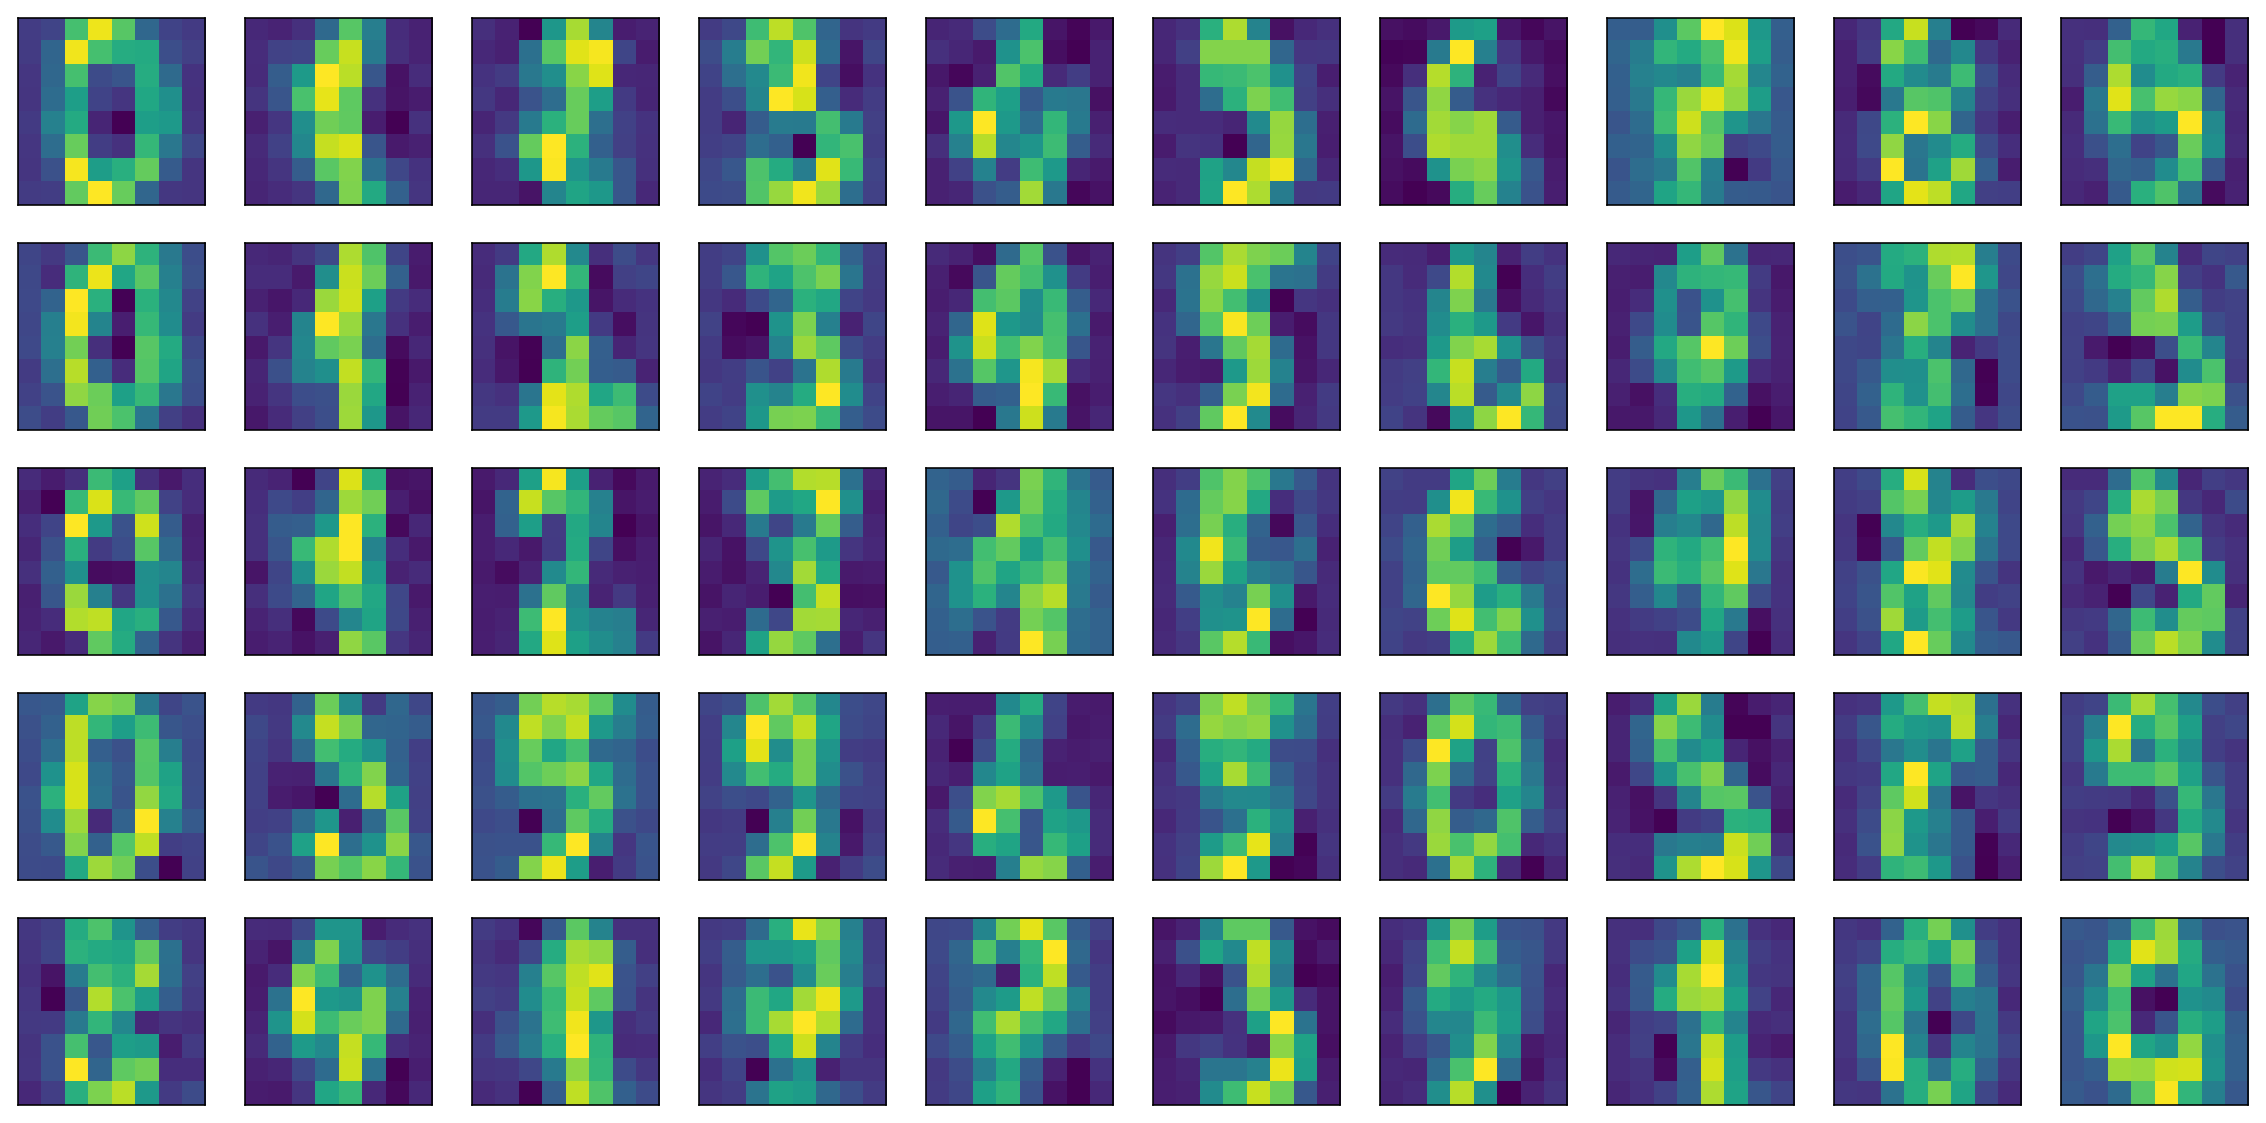

In [94]:
pc = pca.transform(noisy)
filtered = pca.inverse_transform(pc)

plot_digits(filtered)

---
# Eigenfaces

In [95]:
# WARNING !!! This is ~200 MB of data which may take a few minutes to download!
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)

print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [96]:
# number of pixels in each image = number of dimensions in the image space of this image set
62 * 47

2914

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']


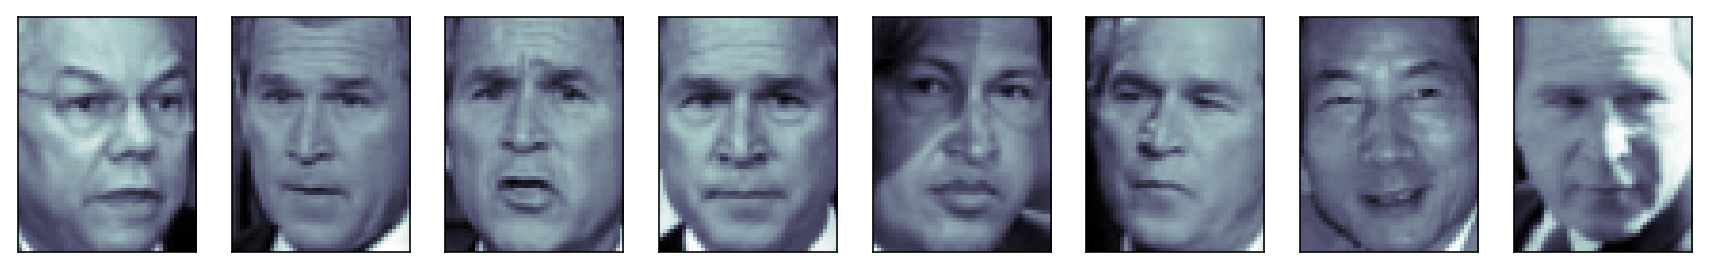

In [97]:
plt.figure(figsize=(15, 5))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(faces.images[i,:,:].reshape(62,47), cmap='bone')
    plt.xticks([])
    plt.yticks([])

print(faces.target_names[:8])

## Project data onto only 150 PCs.

In [98]:
# PCA for first 150 principal components
# Randomized solver performs some approximates to speed up the computation for high dimensional data sets
pca = PCA(n_components=150, svd_solver='randomized')
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='randomized', tol=0.0, whiten=False)

In [99]:
print(pca.components_.shape)

(150, 2914)


## PC0-PC7

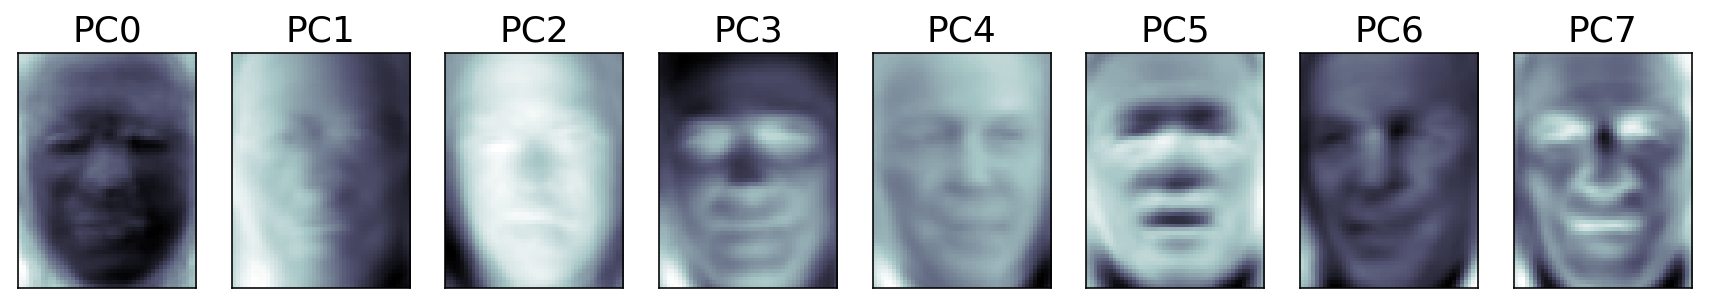

In [100]:
plt.figure(figsize=(15, 5))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(pca.components_[i,:].reshape(62,47), cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'PC{i}')

## How much of the image data variance does the first 150 PCs explain?

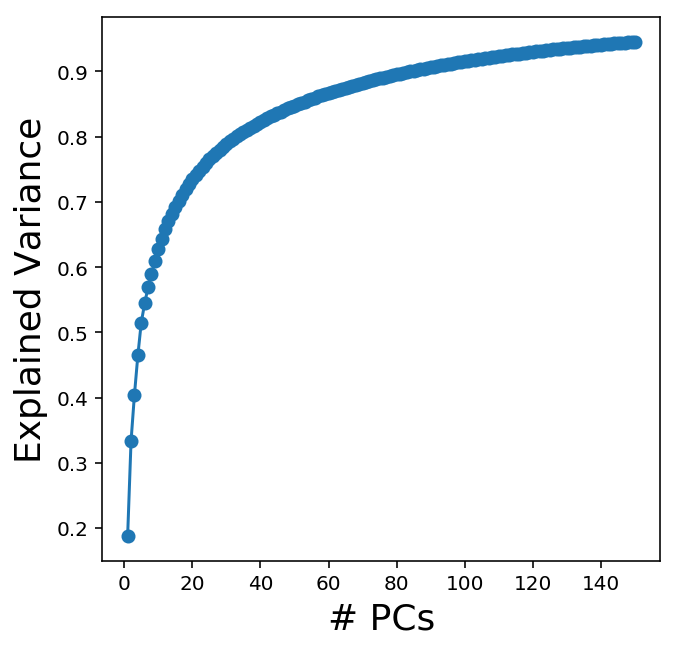

In [101]:
plt.plot(np.arange(1, 151), np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xlabel('# PCs')
plt.ylabel('Explained Variance');

In [102]:
# rotated and compressed
pc = pca.transform(faces.data)

# rotated back
projected = pca.inverse_transform(pc)

print(pc.shape)

(1348, 150)


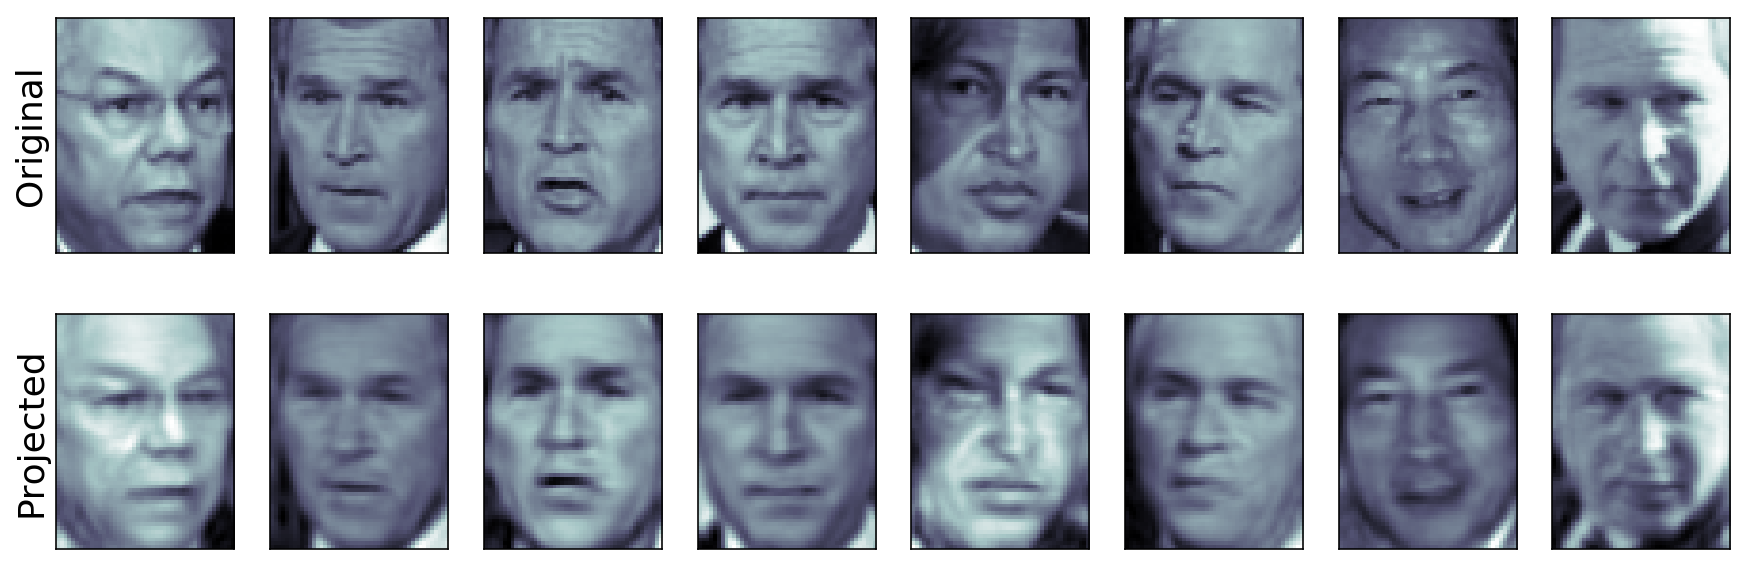

In [103]:
fig, ax = plt.subplots(2, 8, figsize=(15, 5))
for i in range(8):
    # original face
    ax[0,i].imshow(faces.images[i,:,:].reshape(62, 47), cmap='bone')
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    if i == 0:
        ax[0,i].set_ylabel('Original')
    
    # projected face
    ax[1,i].imshow(projected[i,:].reshape(62, 47), cmap='bone')
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    if i == 0:
        ax[1,i].set_ylabel('Projected')

---
# EEG recordings

## <font color=blue>Learning Objectives</font>

1. You will be able to apply PCA to time series.
2. You will be able to classify time series and visualize the classification in a low number of PCs.
3. You will be able to visualize classified time series in higher than three dimensions.
4. You will appreciate how classification of time series waveforms could be beneficial for interpreting experimental data.

In [104]:
mpl.rcParams['figure.figsize'] = (15, 5)

In [105]:
from scipy.io import loadmat

data = loadmat('eeg.mat')

# grab relevant data, EEG units are microvolts (uV)
# each channel is an electrode, each trial is a separate EEG recording from that electrode
eeg_uV = data["EEG"][0,0]["data"]  # [channel, time, trial]
time_ms = data["EEG"][0,0]["times"][0]

eeg_uV.shape, time_ms.shape

((64, 640, 99), (640,))

### `eeg_uV[channel, time point, trial]`

![EEG data structure](images/eeg_data_structure.png)

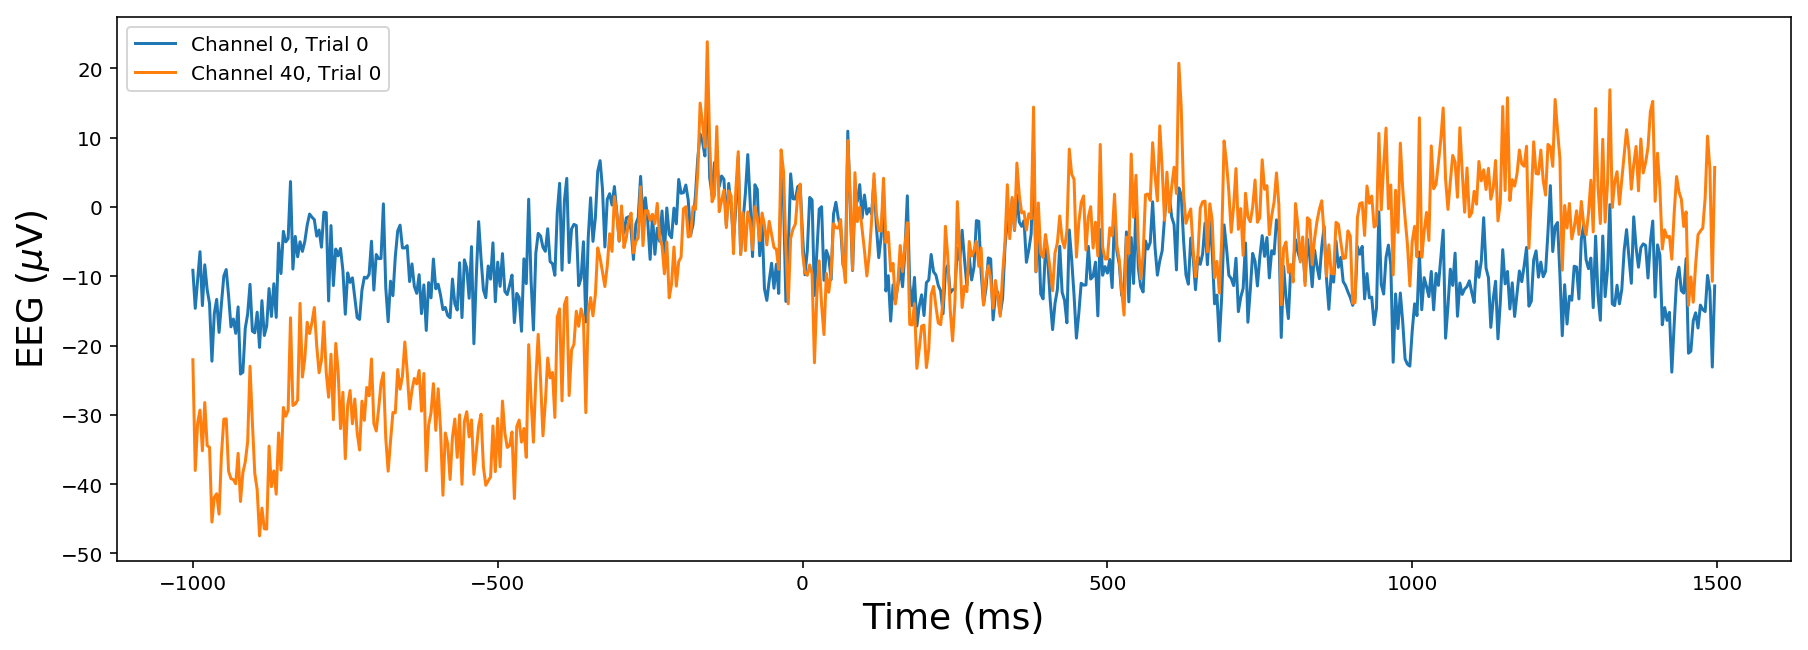

In [106]:
plt.plot(time_ms, eeg_uV[0,:,0], label="Channel 0, Trial 0")
plt.plot(time_ms, eeg_uV[40,:,0], label="Channel 40, Trial 0")
plt.xlabel('Time (ms)')
plt.ylabel('EEG ($\mu$V)')
plt.legend();

## Average EEG across trials in each channel.

![Average EEG data structure](images/avg_eeg_data_structure.png)

In [107]:
avg_eeg_uV = eeg_uV.mean(axis=2)

avg_eeg_uV.shape

(64, 640)

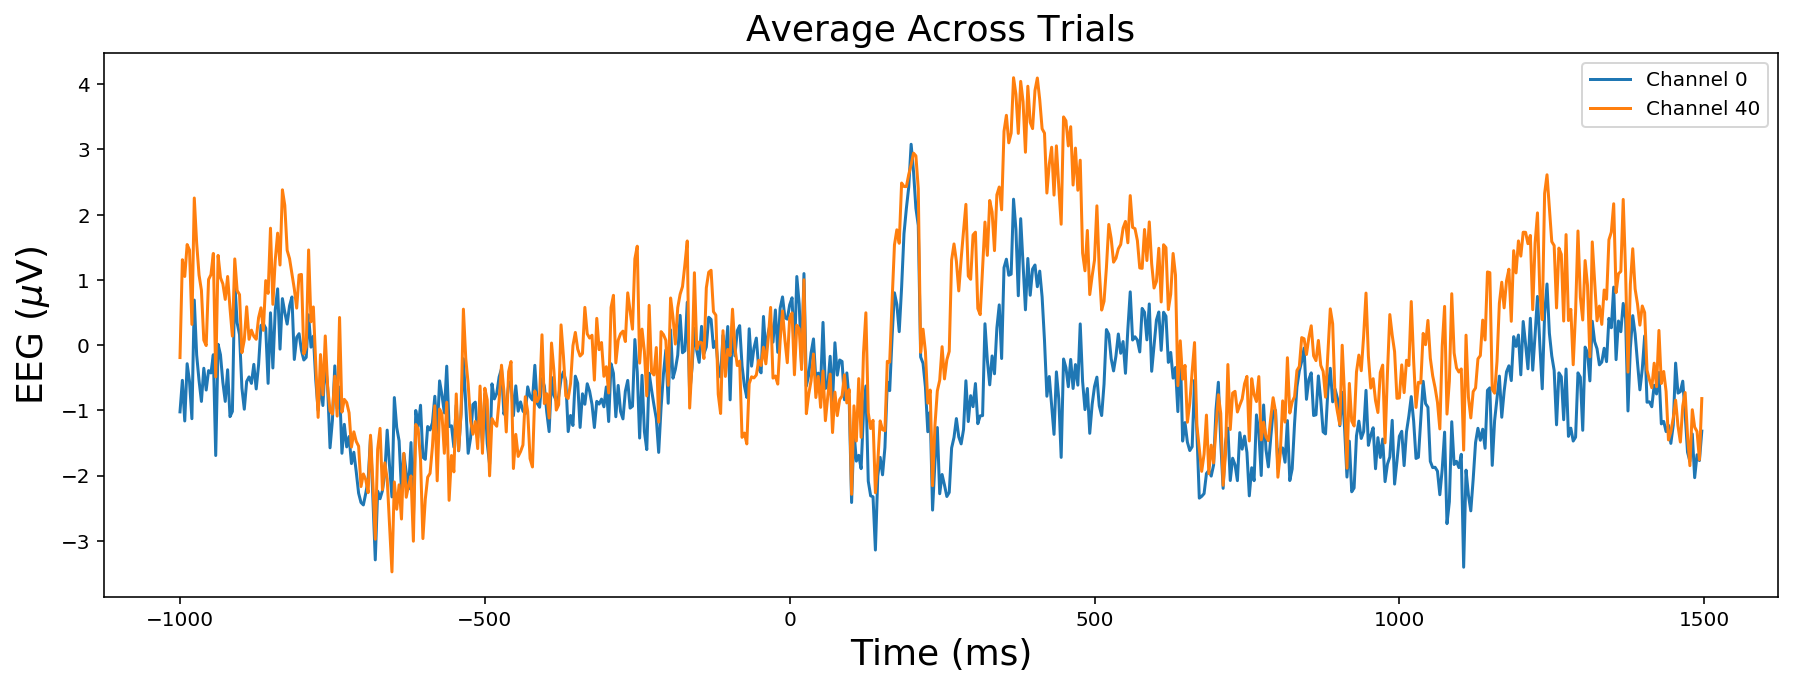

In [108]:
plt.plot(time_ms, avg_eeg_uV[0,:], label="Channel 0")
plt.plot(time_ms, avg_eeg_uV[40,:], label="Channel 40")
plt.xlabel('Time (ms)')
plt.ylabel('EEG ($\mu$V)')
plt.title('Average Across Trials');
plt.legend();

## Each EEG is 640 time points --> a 640-dimensional vector

## <font color=red>Exercises</font>

Should we standardize the EEG data before performing PCA?

Why or why not?

Note: Since each time point is a dimension, this would amount to normalizing the variance across EEGs at each time point.

## Can we explain each EEG with ONLY 3 values instead of 640 values at each time point!?

In [109]:
pca = PCA(3)
pca.fit(avg_eeg_uV)

pca.components_.shape

(3, 640)

## What we're actually doing is explaining each EEG as a mixture of 3 PCs, each of which can itself be thought of as an EEG waveform.

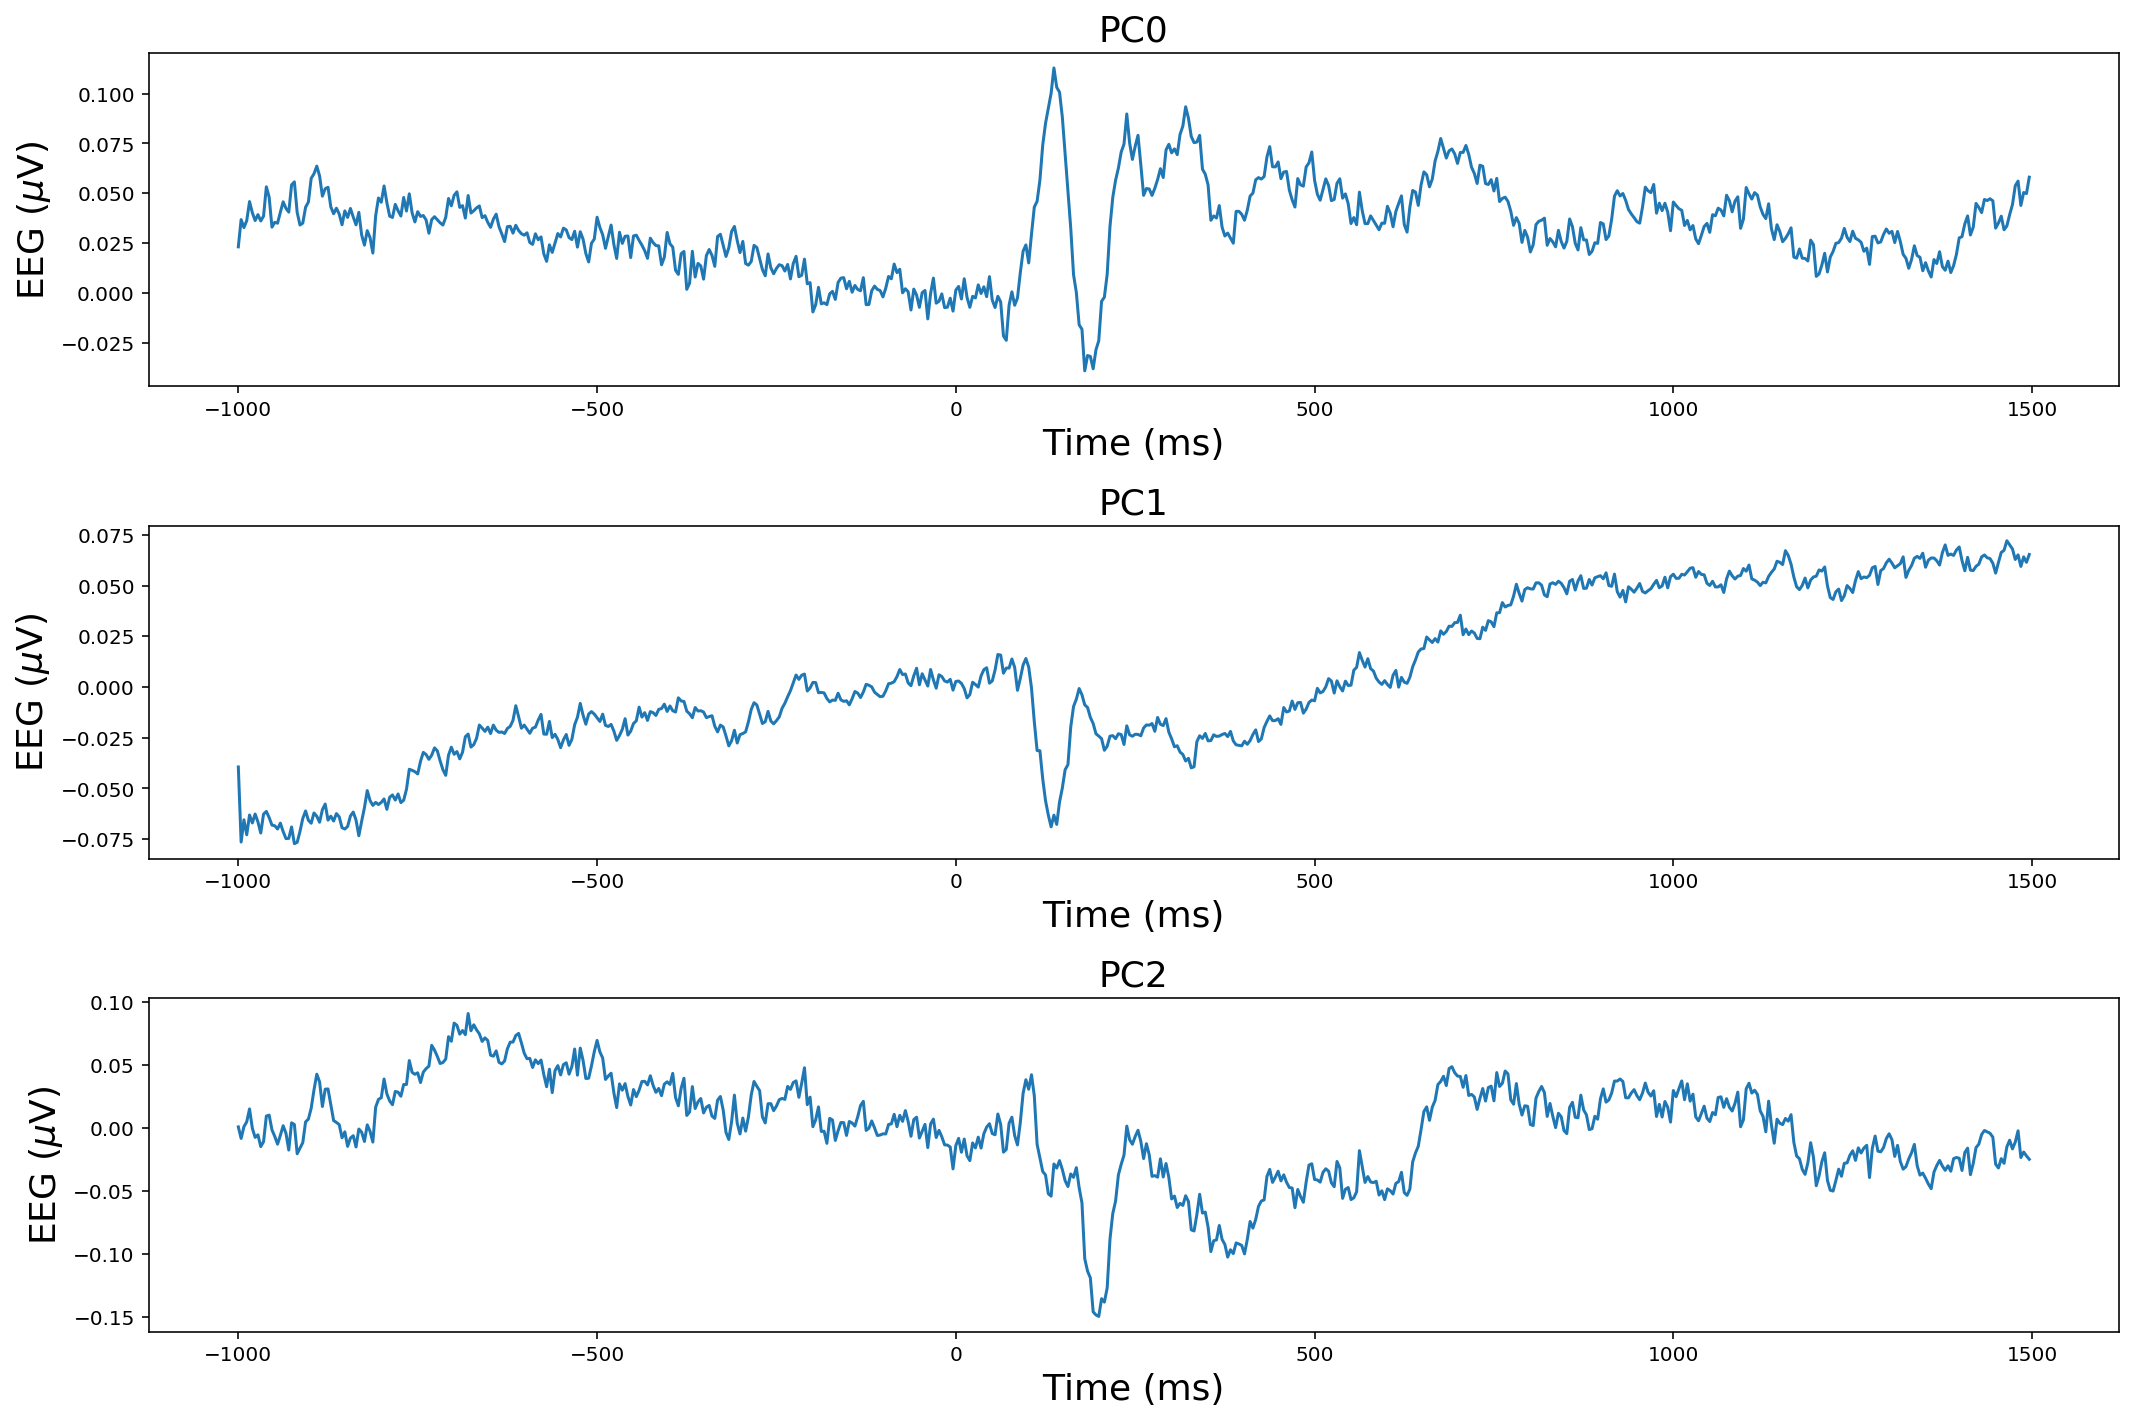

In [110]:
plt.figure(figsize=(15, 10))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(time_ms, pca.components_[i,:])
    plt.xlabel('Time (ms)')
    plt.ylabel('EEG ($\mu$V)')
    plt.title(f'PC{i}')
plt.tight_layout();

## Wow, ~90% of variance explained using ONLY 3 PCs!

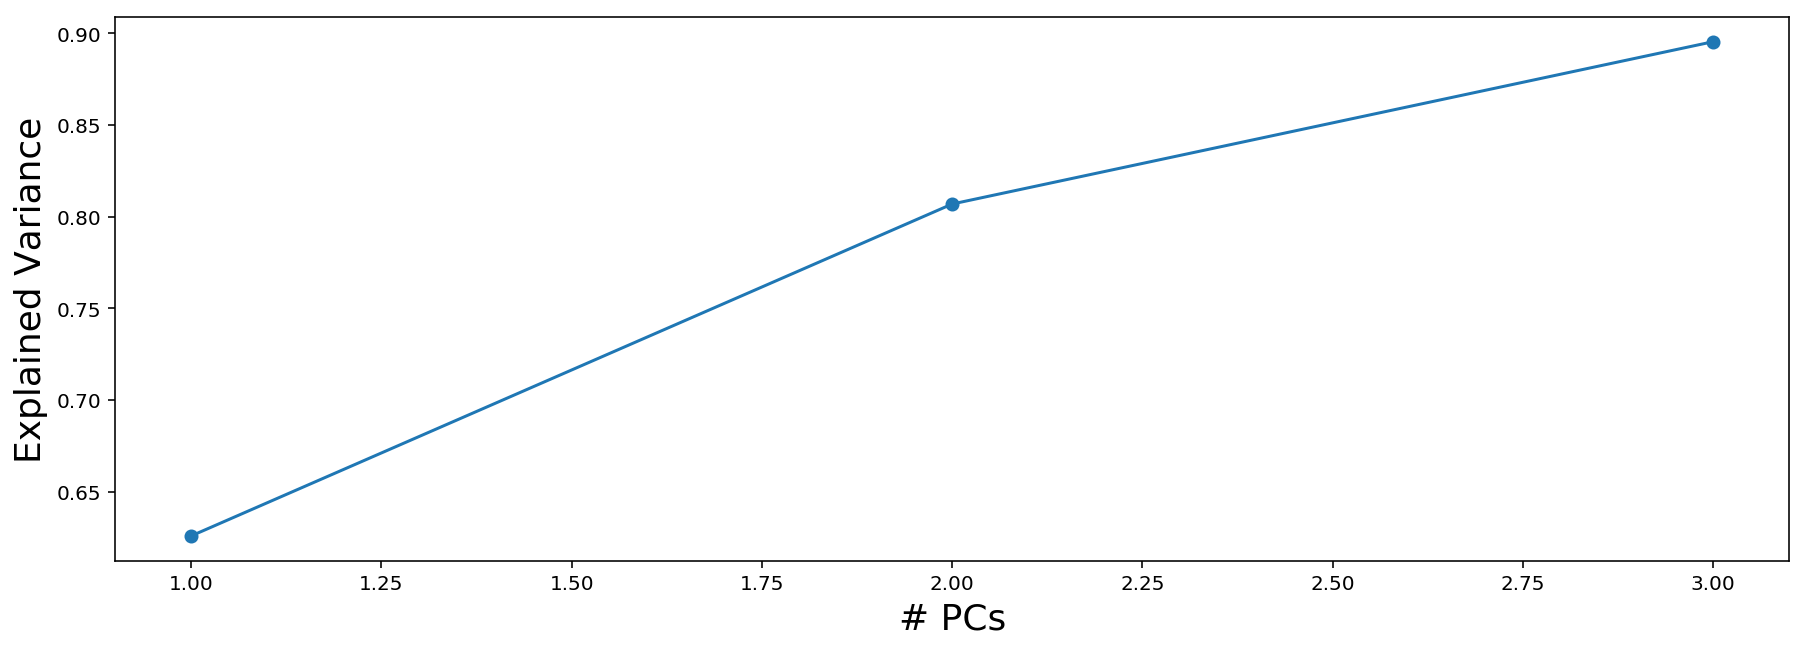

In [111]:
plt.plot(np.arange(1, 4), np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.xlabel('# PCs')
plt.ylabel('Explained Variance');

## `pc` is how much of each of the 3 PCs we need to mix together to explain each of the 64 average EEG waveforms.

In [112]:
pc = pca.transform(avg_eeg_uV)

pc.shape

(64, 3)

In [113]:
print(pc[:5,:])

[[-50.389988    5.4298153   9.518052 ]
 [-44.334618   12.796208    6.0942183]
 [-39.27459    -9.802828    2.435454 ]
 [ -8.723709   32.096085  -19.623268 ]
 [-27.016542    8.502523   -5.0488544]]


## `pca.inverse_transform(pc)` does this mixing for us...

In [114]:
projected = pca.inverse_transform(pc)

projected.shape

(64, 640)

## Let's see how good it did for channel 0...

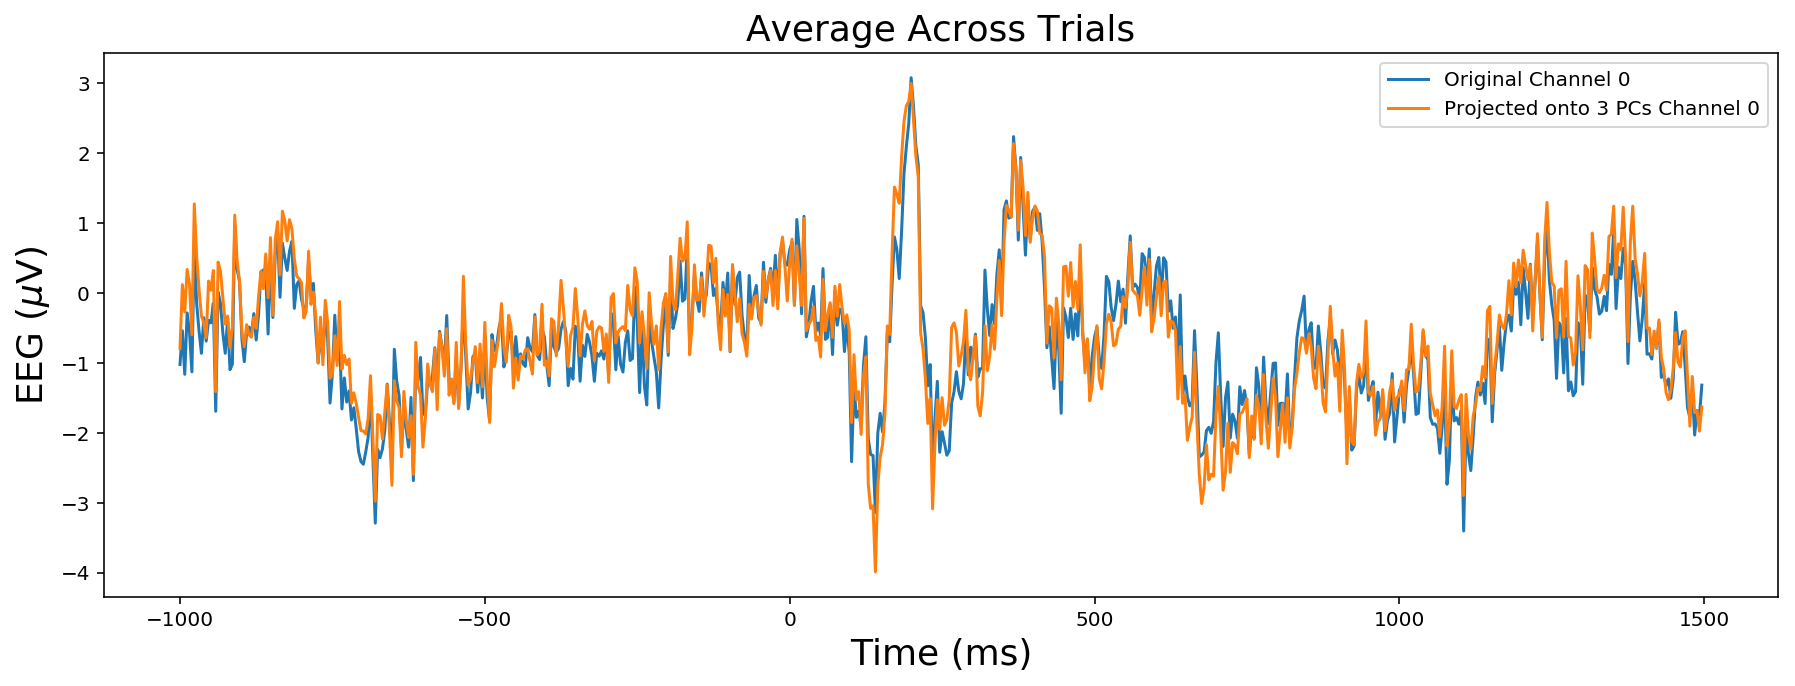

In [115]:
plt.plot(time_ms, avg_eeg_uV[0,:], label="Original Channel 0")
plt.plot(time_ms, projected[0,:], label="Projected onto 3 PCs Channel 0")
plt.xlabel('Time (ms)')
plt.ylabel('EEG ($\mu$V)')
plt.title('Average Across Trials');
plt.legend();

## Let's do the mixing manually so you can explicitly see what's going on...

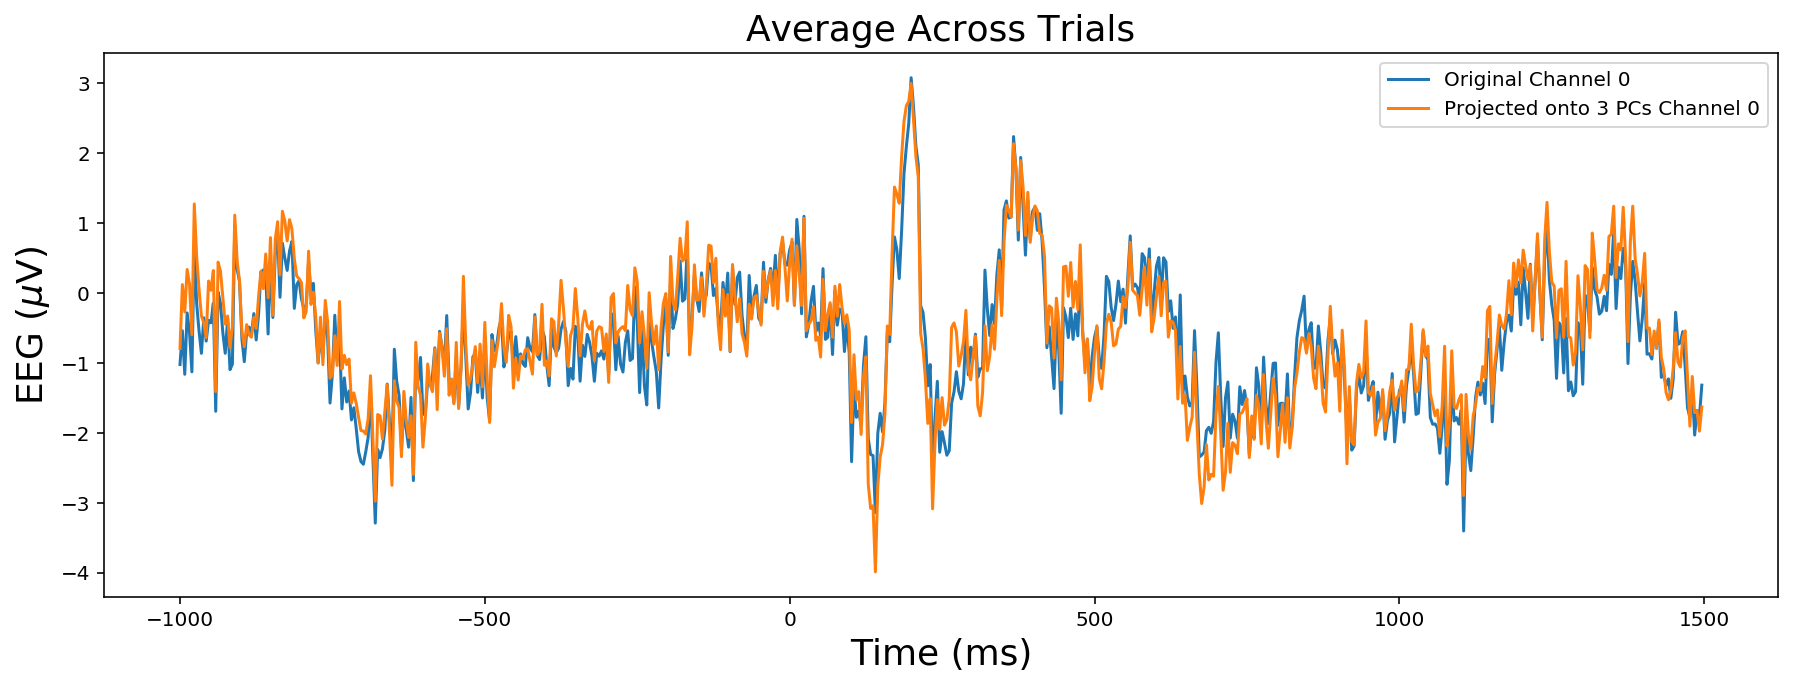

In [116]:
projected0 = avg_eeg_uV.mean(axis=0)
for i in range(3):
    projected0 += pc[0,i] * pca.components_[i,:]

plt.plot(time_ms, avg_eeg_uV[0,:], label="Original Channel 0")
plt.plot(time_ms, projected0, label="Projected onto 3 PCs Channel 0")
plt.xlabel('Time (ms)')
plt.ylabel('EEG ($\mu$V)')
plt.title('Average Across Trials');
plt.legend();

## Let's plot all of our 64 EEG waveforms in the projected 3-dimensional PCA space.

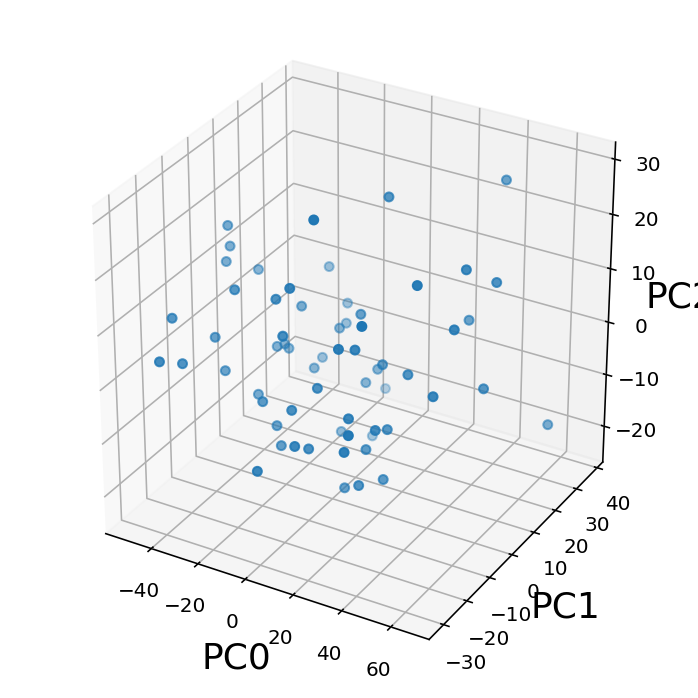

In [117]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(pc[:,0], pc[:,1], pc[:,2])
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
fig.tight_layout();

## Let's try clustering these recordings into two groups using $k$-means...

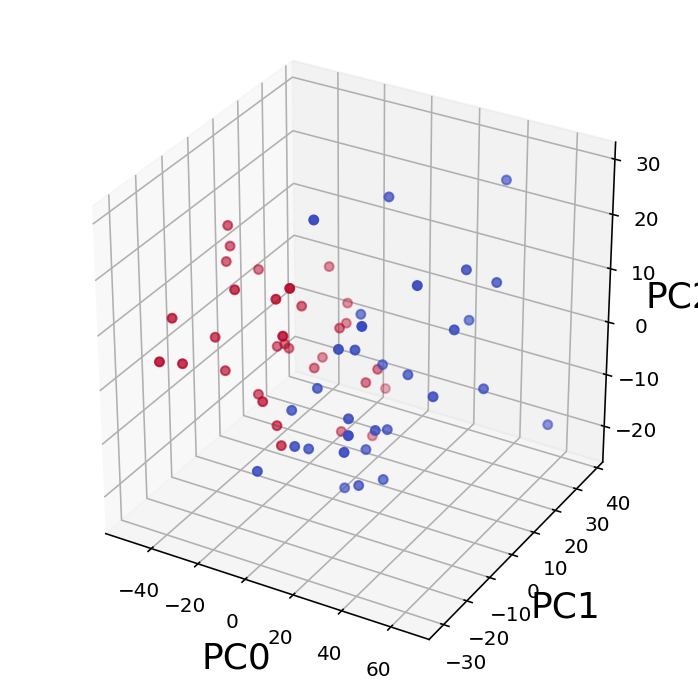

In [125]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(pc)
klabels = kmeans.predict(pc)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=klabels, cmap='coolwarm')
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
fig.tight_layout();

## Do waveforms in each cluster have distinct shapes?

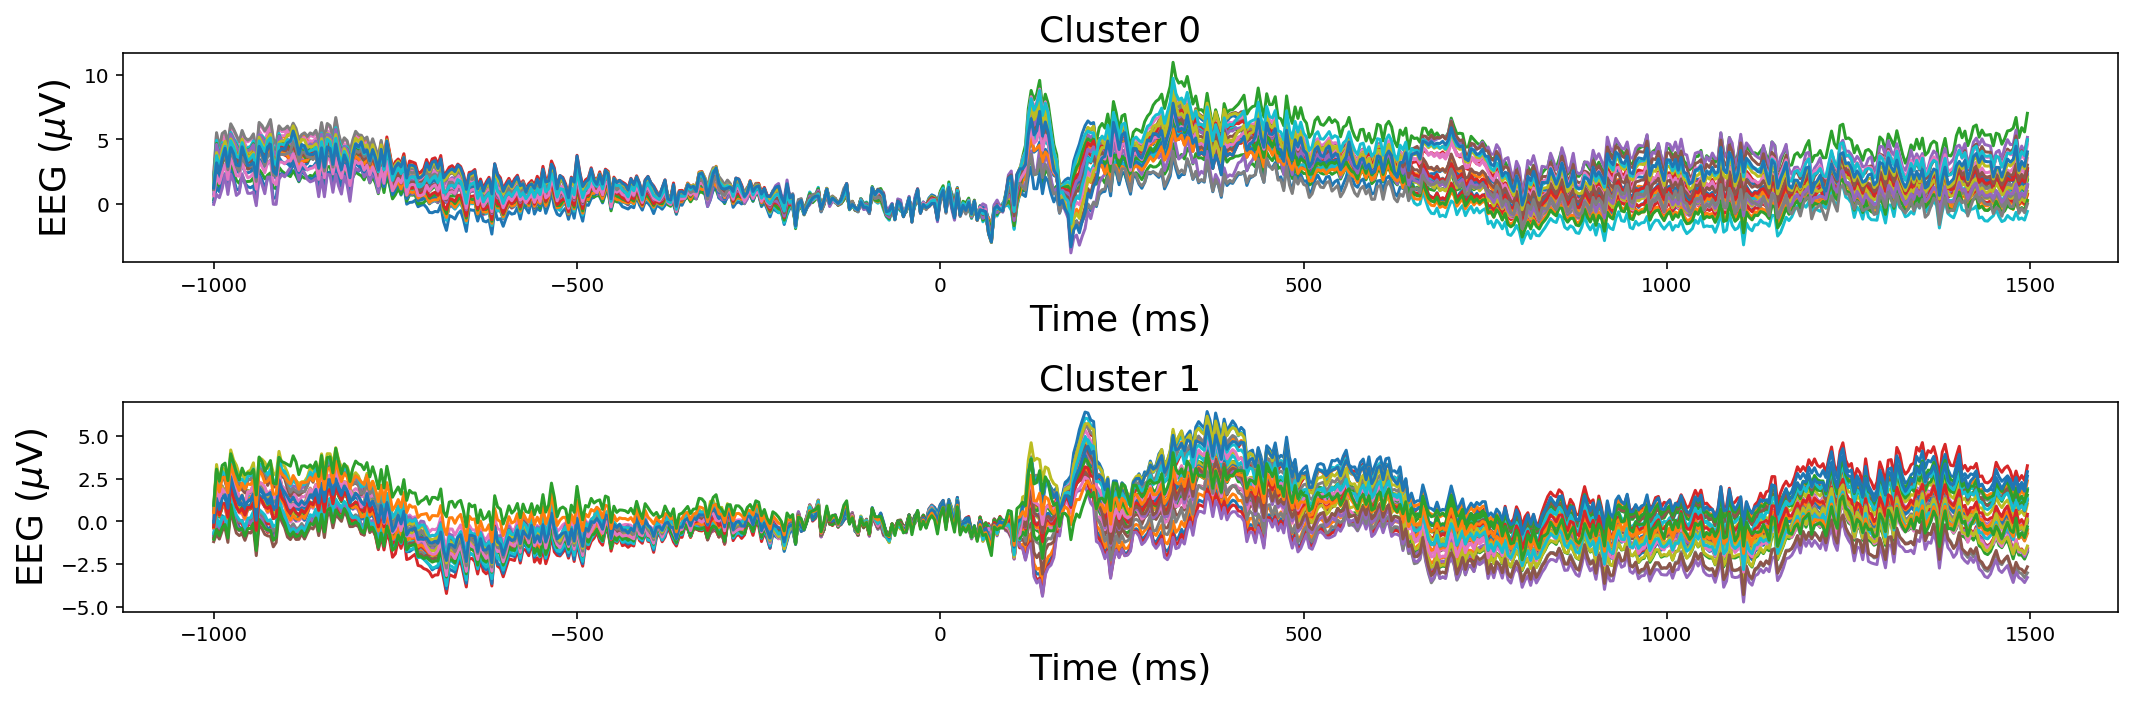

In [127]:
for i in range(64):
    cluster = klabels[i]
    plt.subplot(2, 1, cluster+1)
    plt.plot(time_ms, projected[i,:])
    plt.xlabel('Time (ms)')
    plt.ylabel('EEG ($\mu$V)')
    plt.title(f'Cluster {cluster}')
plt.tight_layout();

## Let's try clustering with a GMM and using BIC or AIC to determine the optimal number of clusters...

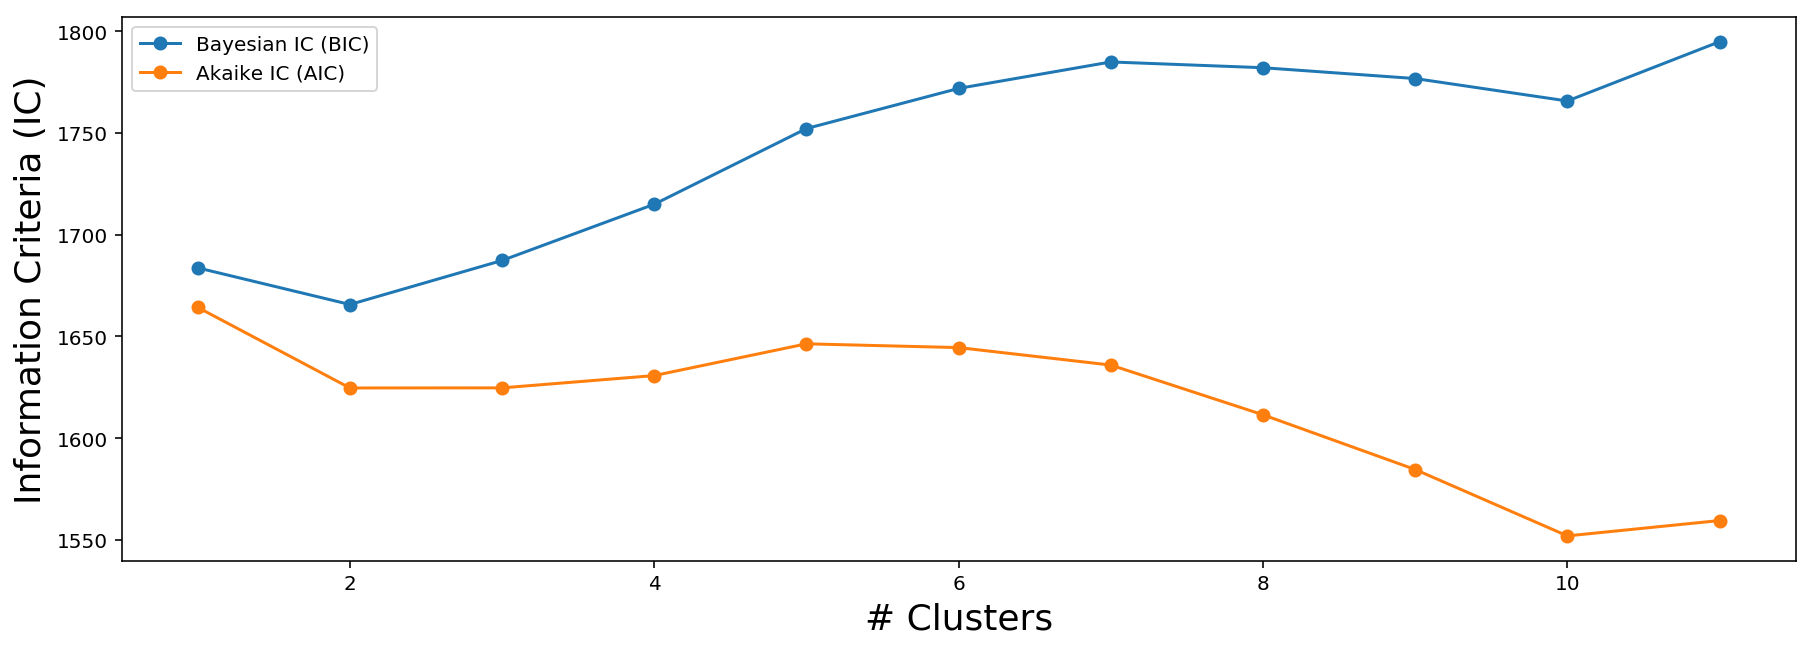

In [128]:
from sklearn.mixture import GaussianMixture

ns = range(1, 12)
models = [GaussianMixture(n_components=n, random_state=0) for n in ns]
for model in models:
    model.fit(pc)
    
bic = [model.bic(pc) for model in models]
aic = [model.aic(pc) for model in models]

plt.plot(ns, bic, 'o-', label='Bayesian IC (BIC)')
plt.plot(ns, aic, 'o-', label='Akaike IC (AIC)')
plt.xlabel('# Clusters');
plt.ylabel('Information Criteria (IC)')
plt.legend();

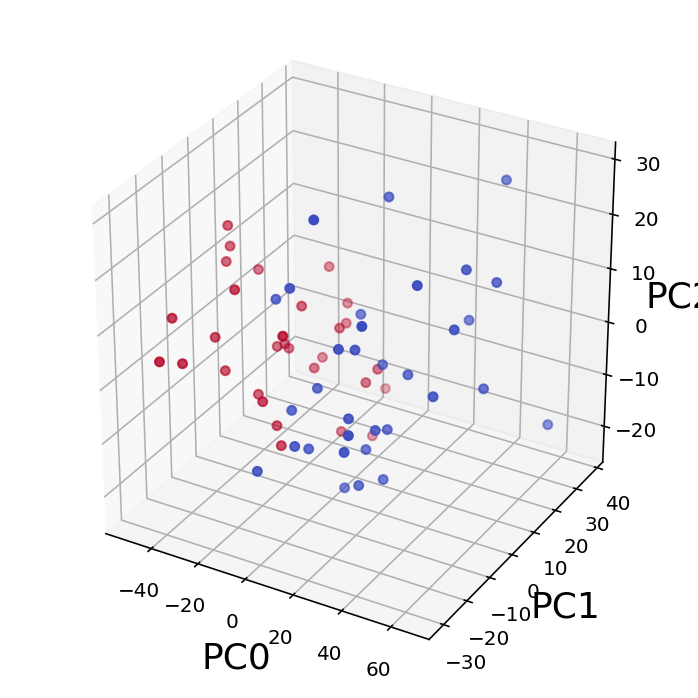

In [129]:
gmm = GaussianMixture(n_components=2)
gmm.fit(pc)
glabels = gmm.predict(pc)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=glabels, cmap='coolwarm')
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
fig.tight_layout();

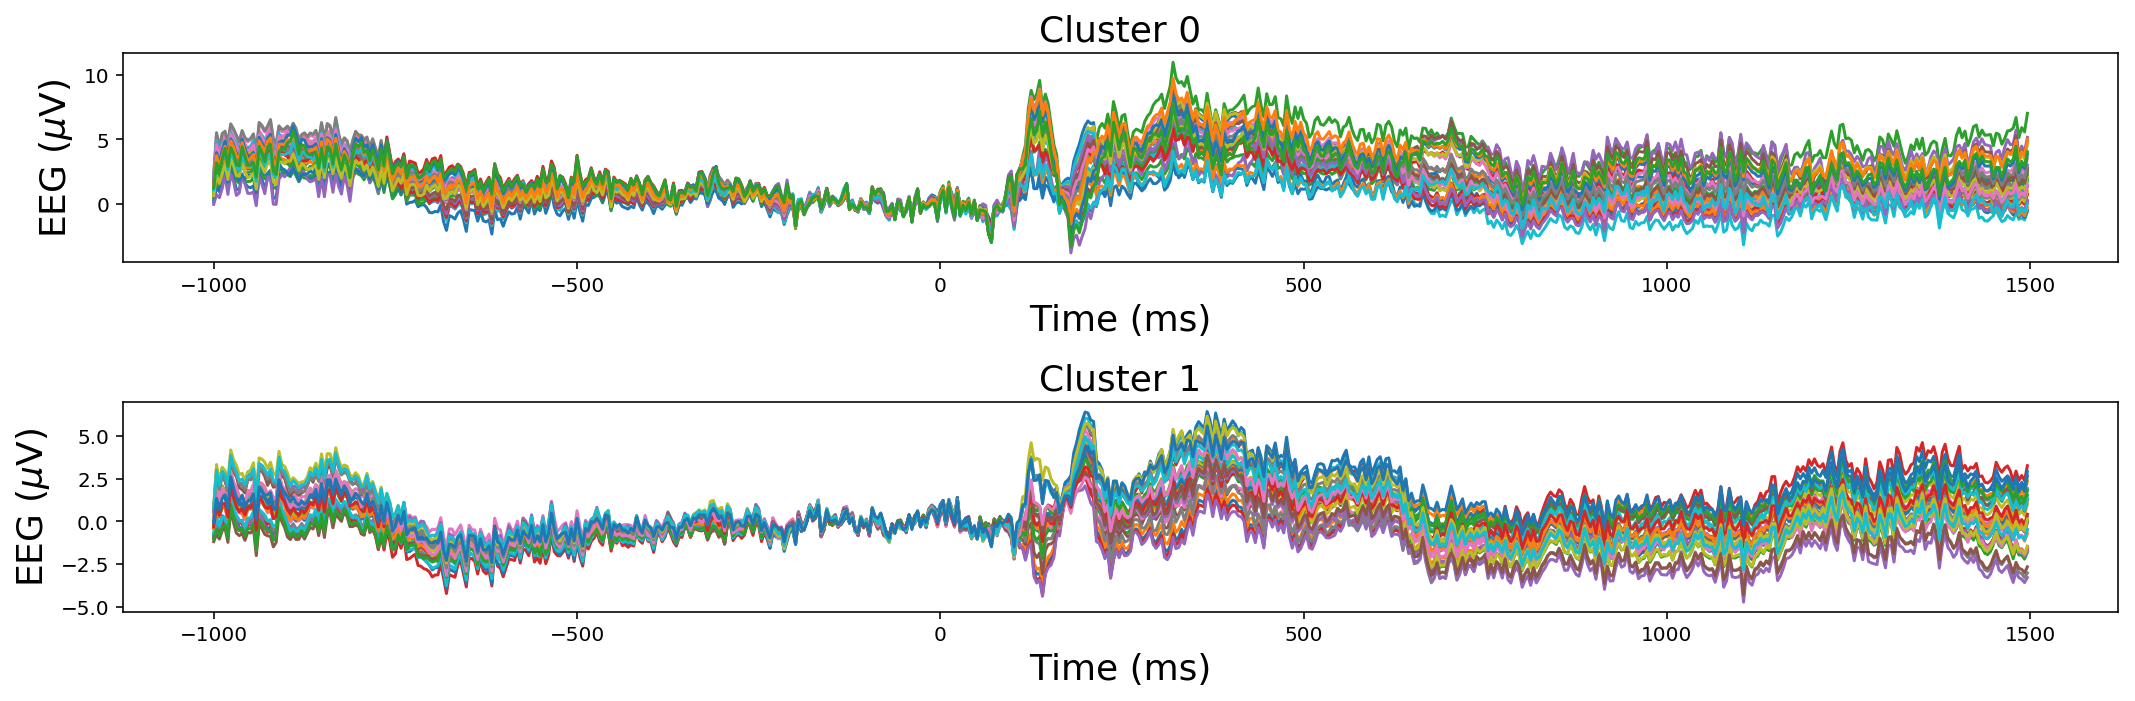

In [131]:
for i in range(64):
    cluster = glabels[i]
    plt.subplot(2, 1, cluster+1)
    plt.plot(time_ms, projected[i,:])
    plt.xlabel('Time (ms)')
    plt.ylabel('EEG ($\mu$V)')
    plt.title(f'Cluster {cluster}')
plt.tight_layout();

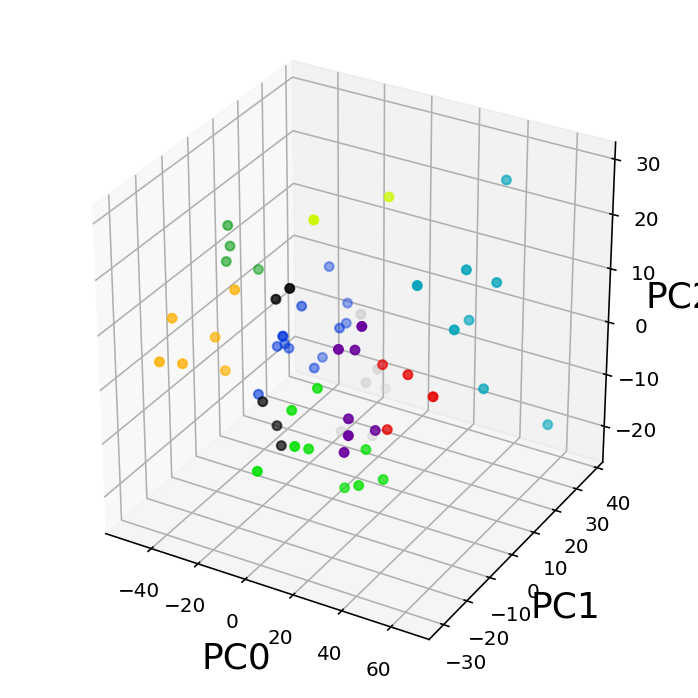

In [132]:
gmm = GaussianMixture(n_components=10)
gmm.fit(pc)
glabels = gmm.predict(pc)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=glabels, cmap=plt.cm.get_cmap('nipy_spectral', 10))
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
fig.tight_layout();

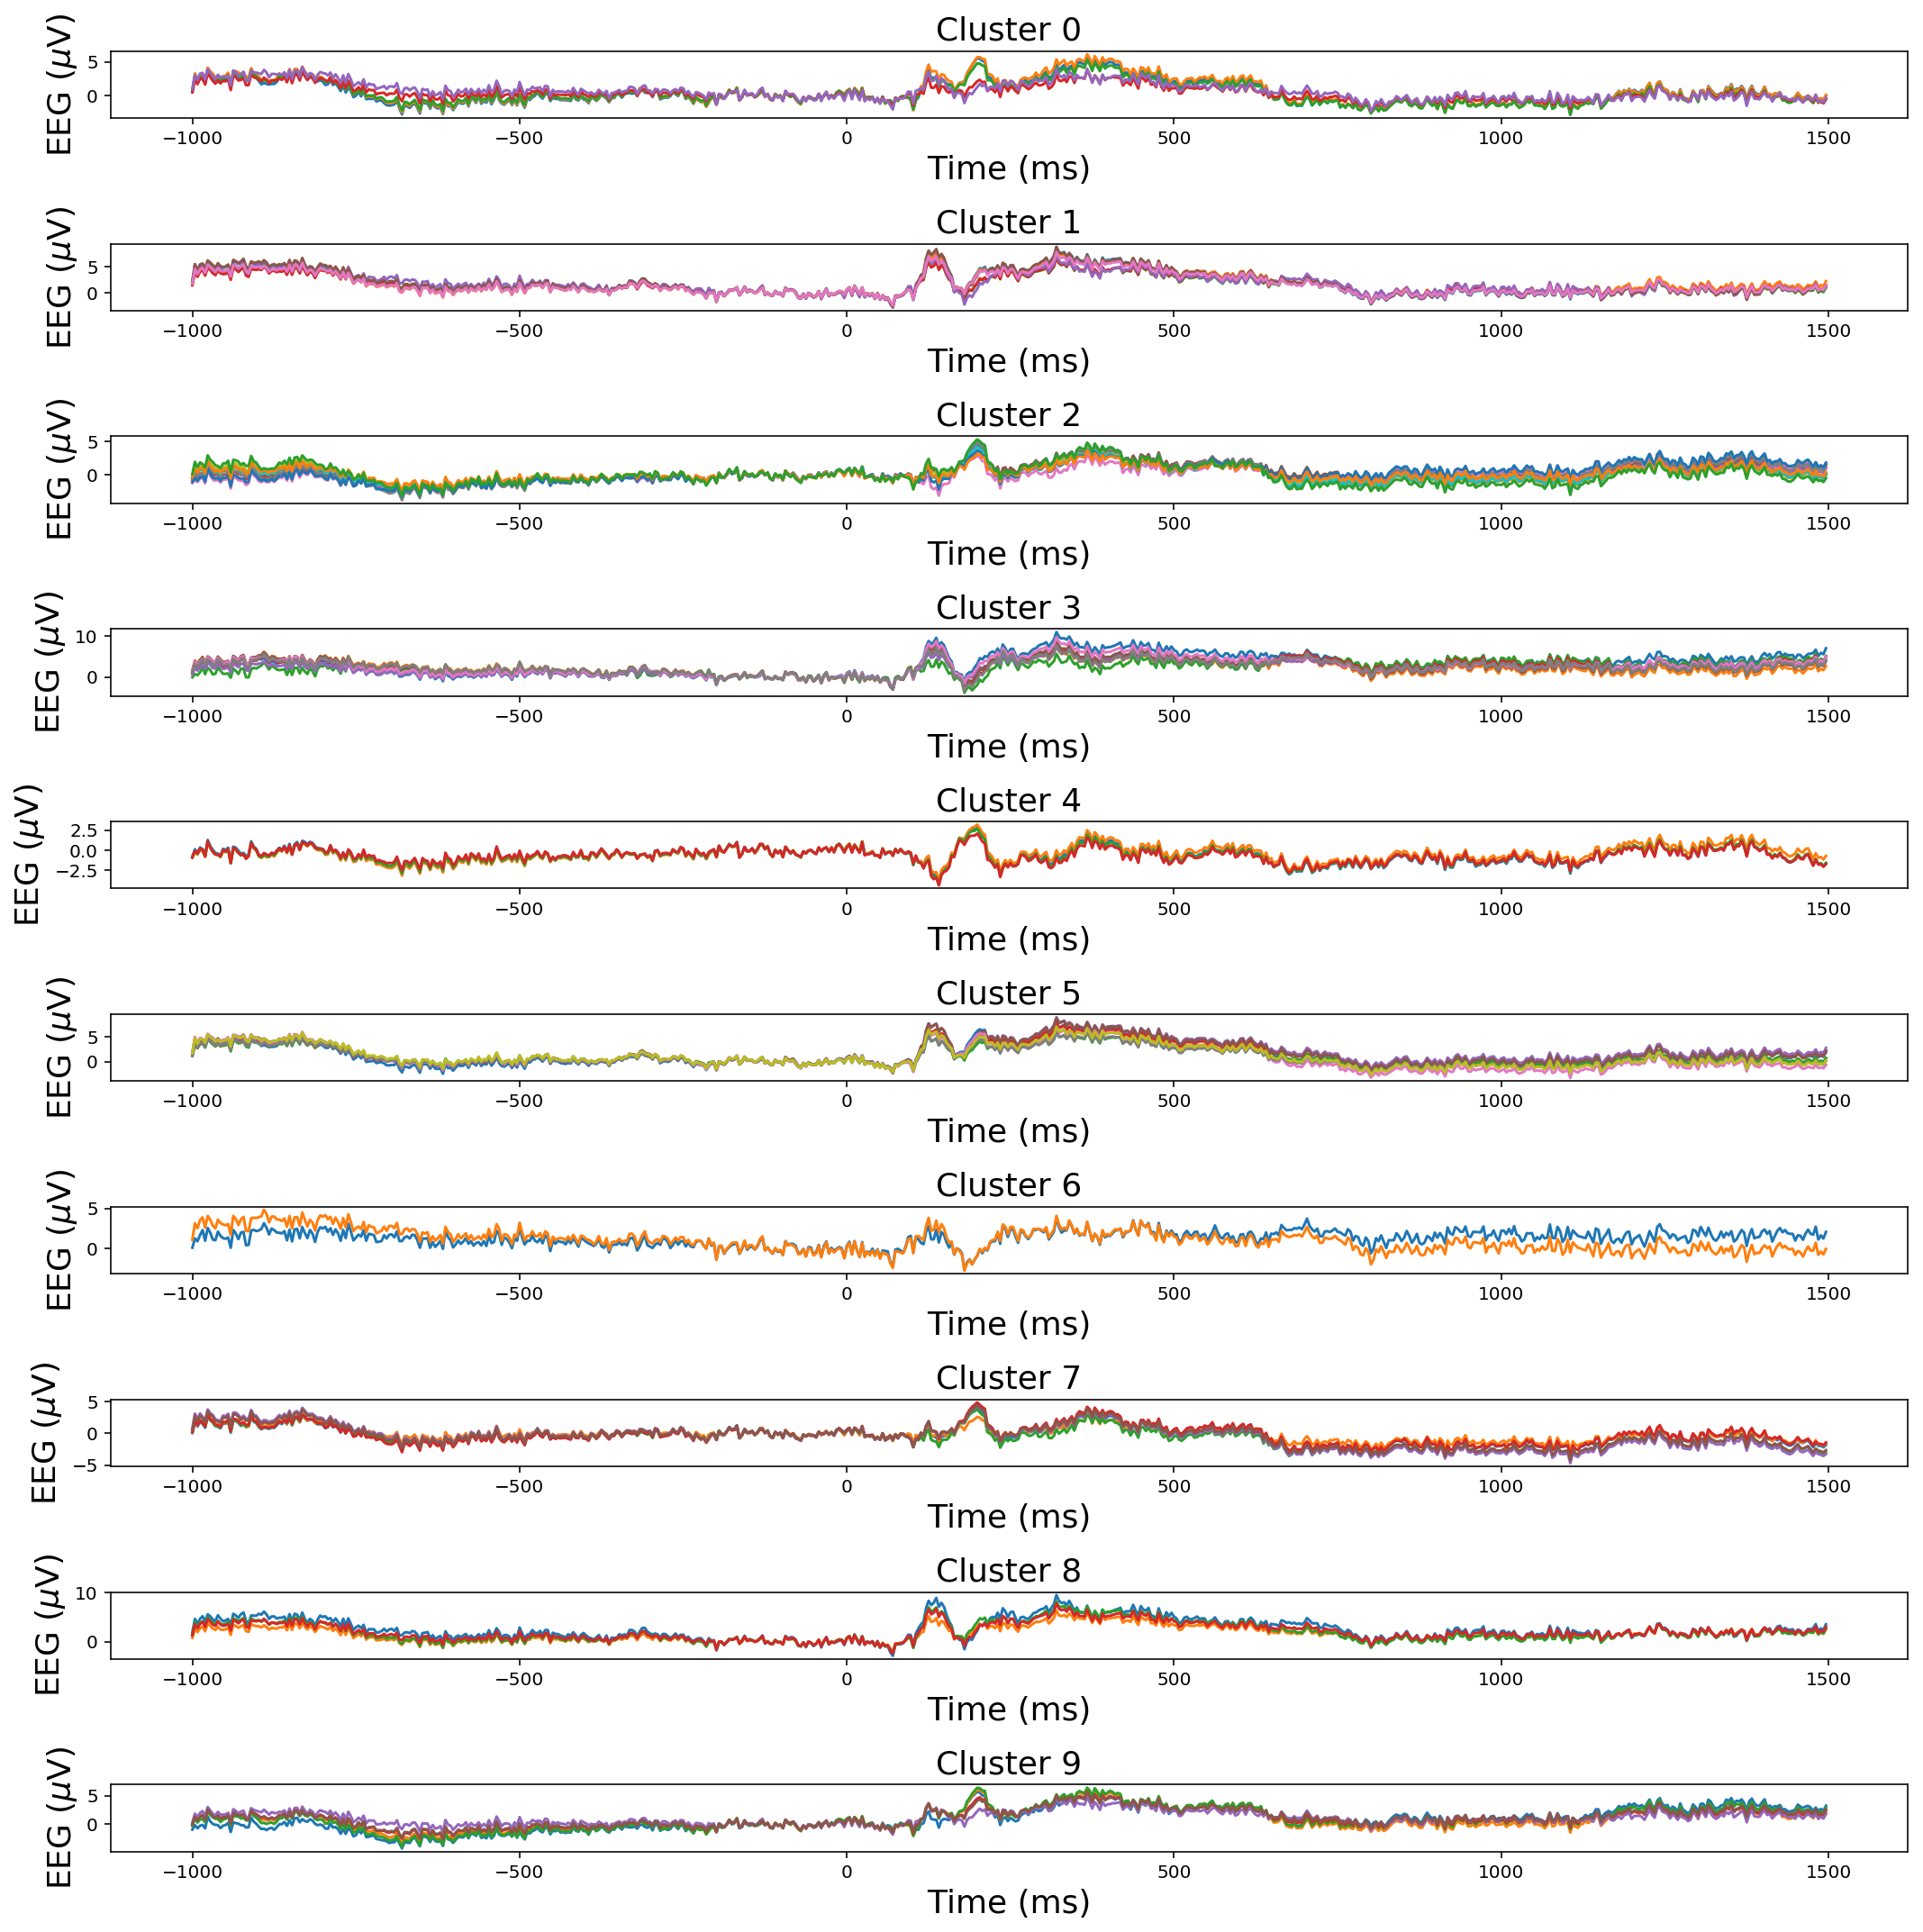

In [134]:
plt.figure(figsize=(15, 15))
for i in range(64):
    cluster = glabels[i]
    plt.subplot(10, 1, cluster+1)
    plt.plot(time_ms, projected[i,:])
    plt.xlabel('Time (ms)')
    plt.ylabel('EEG ($\mu$V)')
    plt.title(f'Cluster {cluster}')
plt.tight_layout();